 # Organisation Mondiale de lutte contre le faux-monnayage
 
 
 ![logo](media/Logo.png)
 
 ## Rappel des Missions : 
 
Mettre en place des méthodes d'identification des contrefaçons des billets en euros.
Mettre en place une modélisation capable d'identifier automatiquement les vrais des faux billets, à partir des dimensions du billet et des éléments qui le composent.

## Méthode employée en première intention:
***Ce processus pourra évoluer au cours de la réalisation du travail***

- Nettoyage/Exploration des données fournies.
- Détermination de la définition d'un vrai/faux billet et d'un algorithme "naif"
- Mise en place et évaluation de plusieurs algorithmes de Machine Learning en concurrence du modèle "naif"
- Choix du modèle le plus approprié
- Mise en production.

## Import des outils et librairies


In [1]:
# Import des librairies

#gestion des images
from IPython.display import Image
from IPython.core.display import HTML

#gestion des dataframes
import pandas as pd
import numpy as np

#gestion des graphiques
import seaborn as sns
sns.set(rc={'figure.facecolor':'lightblue'})
import plotly.express as px
import matplotlib.pyplot as plt

# gestion statistiques
import scipy.stats as stat

# import de fonctions pour l'ACP
from functions import *

# gestion algorithmes de ML
from sklearn import metrics
# matrice de confusion pour contrôles
from sklearn.metrics import confusion_matrix

# regression linéaire
import scipy as st
from sklearn.linear_model import LinearRegression
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

# centrage réduction
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
# Composantes principales
from sklearn.decomposition import PCA
# data prep
from sklearn.model_selection import train_test_split
# Kmeans
from sklearn.cluster import KMeans
# KNN
from sklearn.neighbors import KNeighborsClassifier

# Regression logistique
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_curve,  auc
# gestion des warnings
import warnings
warnings.filterwarnings('ignore')

# random seed
np.random.seed(2692)

## Import des données

In [2]:
# Import des fichiers de données

# Fichier de billets à tester
ToTestSample = pd.read_csv("DataStore/billets_production.csv")
# Fichier de billets exemples
ExampleSet = pd.read_csv("DataStore/billets.csv", sep=";")

## Création de fonctions utiles

In [3]:
# Fonction pour afficher les levels de données et leur valeurs
def inspect_data(data):
    return pd.DataFrame({"Data Type": data.dtypes,
                         "No of Levels": data.apply(lambda x: x.nunique(), axis=0),
                         "Levels": data.apply(lambda x: str(x.unique()), axis=0)})

# Fonction sns scatterplot deux variables + titre 
def scatter(col1, col2, title ):
    plt.title(title)
    sns.scatterplot(ExampleSet[col1], ExampleSet[col2], hue=ExampleSet["is_genuine"])

# même fonction sans le hue sur is_genuine
def scatter2(col1, col2, title ):
    plt.title(title)
    sns.scatterplot(ExampleSet[col1], ExampleSet[col2])
    
# fonction sns FacetGrid une variable
def facet(col):
    sns.FacetGrid(ExampleSet, hue="is_genuine", height=5).map(sns.distplot, col).add_legend()

# colinearité des variables
def calculate_vif(df, features):    
    vif, tolerance = {}, {}
    # all the features that you want to examine
    for feature in features:
        # extract all the other features you will regress against
        X = [f for f in features if f != feature]        
        X, y = df[X], df[feature]
        # extract r-squared from the fit
        r2 = LinearRegression().fit(X, y).score(X, y)                
        
        # calculate tolerance
        tolerance[feature] = 1 - r2
        # calculate VIF
        vif[feature] = 1/(tolerance[feature])
    # return VIF DataFrame
    return pd.DataFrame({'VIF': vif, 'Tolerance': tolerance})

# couleurs dans un df true/false
def color_df(val):
    if val == True:
        color = "green"
    elif val == False:
        color = 'red'
    else:
        color = 'black'
    return 'color: %s' % color

## création de Dataframes et de variables utiles
***Calculs en tout genres utilisés bien plus loin dans l'analyse***

In [4]:
# Calculs géométriques

# création d'un df ne contenant pas les valeurs null 
notnullset = ExampleSet[ExampleSet["margin_low"].isnull()==False]

#calcul de la moyenne de la hauteur "(hauteur droite + hauteur gauche)/2"
notnullset["mean_h"] = (notnullset["height_left"]+notnullset["height_right"])/2

# calcul de la hauteur de  l'impression du billet "hauteur - (marge haute + marge basse)"
notnullset["printed_h"] = (notnullset["mean_h"]-(notnullset['margin_up']+notnullset['margin_low']))

# création de dataframe ne contenant que les billets autentiques
notnulltrue = notnullset[notnullset['is_genuine']==True]

# création de dataframe ne contenant que les billets factices
notnullfalse = notnullset[notnullset['is_genuine']==False]


# création de variables

# Moyenne et médiane de la hauteur d'impression
printedmean_h = notnullset.printed_h.mean()
printedmedian_h = notnullset.printed_h.median()

# Moyenne et médiane de la hauteur d'impression pour les billets authentiques
trueprintedmean_h = notnulltrue.printed_h.mean()
trueprintedmedian_h = notnulltrue.printed_h.median()

# Moyenne  et médiane de la hauteur d'impression pour les billets factices
falseprintedmean_h = notnullfalse.printed_h.mean()
falseprintedmedian_h = notnullfalse.printed_h.median()

# calcul géométrique de la margin_low "hauteur moyenne -(marge haute + moyenne de la hauteur de l'impression)"

# pour le set complet
notnullset["geom_calc_margin_low"] = (notnullset['mean_h'] -(notnullset['margin_up']+printedmean_h))

# pour les billets authentiques
notnulltrue["geom_calc_margin_low"] = (notnulltrue['mean_h'] -(notnulltrue['margin_up']+trueprintedmean_h))

# pour les billets factices
notnullfalse["geom_calc_margin_low"] = (notnullfalse['mean_h'] -(notnullfalse['margin_up']+falseprintedmean_h))

# concaténation des df contenant les billets authentiques et les billets factices
reunitedset = pd.concat([notnullfalse,notnulltrue])

# Calcul des differences de hauteur entre la marge basse donnée et celle calculée géométriquement

# pour l'ensemble des billets
notnullset["diff_h"] = (notnullset["margin_low"]-notnullset["geom_calc_margin_low"])

# pour les billets vrai et faux traités séparément.
reunitedset["diff_h"] = (reunitedset["margin_low"]-reunitedset["geom_calc_margin_low"])

# création de variables pour algorithme naif

longueur_mini = np.percentile(notnulltrue.length, 5)
margin_low_max = np.percentile(notnulltrue.margin_low, 95)

## algorithme naif de reconnaissance sur ExampleSet

#selection des lignes correspondant aux conditions pour qu'un billet soit authentique
genuine_test = notnullset[(notnullset.length > longueur_mini)]
genuine_test = genuine_test[(genuine_test.margin_low < margin_low_max)]

# contrôle qualité de l'algorithme naif
test_pool = notnullset.shape[0]
tested_true = genuine_test.shape[0]
tested_false = test_pool-tested_true
real_fake = notnullfalse.shape[0]
fake_false = tested_false-real_fake 
fake_true = (genuine_test[genuine_test.is_genuine == False].shape[0])
real_true = notnulltrue.shape[0]

## algorithme naif de reconnaissance sur ToTestSample

Naive_test = ToTestSample
Naive_test["valid_length"] = np.where(Naive_test['length']>longueur_mini,1 ,0)
Naive_test["valid_margin_low"] = np.where(Naive_test['margin_low']<margin_low_max,1 ,0)
Naive_test["Naive"]=np.where((Naive_test['valid_length']+Naive_test['valid_margin_low'])==2,True,False)

## fonction reconnaissance naive

In [5]:
# fonction pour appliquer l'algorithme naif de reconnaissance
def naive_recon(df):
    df["valid_length"] = np.where(df['length']>longueur_mini,1 ,0)
    df["valid_margin_low"] = np.where(df['margin_low']<margin_low_max,1 ,0)
    df["Naive"]=np.where((df['valid_length']+df['valid_margin_low'])==2,True,False)
    df.drop(columns=['valid_length', 'valid_margin_low'], inplace=True)
    return df['Naive']

## Visualisation des données fournies

In [6]:
# On commence ici par le fichier de billets à tester

ToTestSample

,diagonal,height_left,height_right,margin_low,margin_up,length,id,valid_length,valid_margin_low,Naive
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,0,0,False
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,0,0,False
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,0,0,False
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,1,1,True
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,1,1,True


Ce fichier contient pour chaque billet à tester une liste de variables dimensionnelles et un *id*

In [7]:
# On poursuit avec le fichier de billets exemple

ExampleSet.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


Ce fichier contient pour chaque billet une liste de variables dimensionnelles et leur autenthicité : "is_genuine"

# EDA d'exemple de billets

***Comment caractériser l'authenticité d'un billet?***

## Signification des valeurs fournies

On considère que pour chaque billets sont fournis la liste des valeurs suivantes:

- diagonal: la diagonale
- height_left: la hauteur totale du billet à gauche
- height_right: la hauteur totale du billet à droite
- margin_low: la distance entre le bord bas de l'impression et le bord bas du billet
- margin_up: la distance entre le bord haut de l'impression et le bord  haut du billet
- length: la longueur totale du billet

Toutes les dimensions sont données en mm.

## Généralités

### Forme et format de données

In [8]:
# forme et format de données

print(ExampleSet.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB
None


le tableau est constitué de 7 observations (variables) pour 1500 individus (billets).

is_genuine est un booleen (True/False), les autres observations sont de type Float.

Margin_low est le seul à contenir des nulls (37/1500), nous trouverons une solution pour les remplir en fin d'EDA.

### Contenu des données

In [9]:
# Valeurs dupliquées?

ExampleSet.duplicated().sum()

0

Le fichier ne contient pas de valeurs dupliquées

In [10]:
# Utilisation de la fonction inspect_data qui permet d'afficher les levels et leurs valeurs.

inspect_data(ExampleSet)

,Data Type,No of Levels,Levels
is_genuine,bool,2,[ True False]
diagonal,float64,159,[171.81 171.46 172.69 171.36 171.73 172.17 172...
height_left,float64,155,[104.86 103.36 104.48 103.91 104.28 103.74 104...
height_right,float64,170,[104.95 103.66 103.5 103.94 103.46 104.08 103...
margin_low,float64,285,[4.52 3.77 4.4 3.62 4.04 4.42 4.58 3.98 4. ...
margin_up,float64,123,[2.89 2.99 2.94 3.01 3.48 2.95 3.26 2.92 3.25 ...
length,float64,336,[112.83 113.09 113.16 113.51 112.54 112.81 113...


Les "levels" sont les valeurs uniques que peuvent prendre chaque observation. On remarquera que **length** et **margin_low** sont les deux observations avec le plus grand nombre de levels.

In [11]:
# Analyse rapide des variables de type "Float"

ExampleSet.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


Ici on constate que l'ecart type (Standard Deviation ou std en anglais) est plus important pour les observations **length** et **margin_low**

In [12]:
print(ExampleSet.groupby('is_genuine').describe().T)

is_genuine               False        True 
diagonal     count  500.000000  1000.000000
             mean   171.901160   171.987080
             std      0.306861     0.300441
             min    171.040000   171.040000
             25%    171.690000   171.790000
             50%    171.910000   171.990000
             75%    172.092500   172.200000
             max    173.010000   172.920000
height_left  count  500.000000  1000.000000
             mean   104.190340   103.949130
             std      0.223758     0.300231
             min    103.510000   103.140000
             25%    104.040000   103.740000
             50%    104.180000   103.950000
             75%    104.332500   104.140000
             max    104.880000   104.860000
height_right count  500.000000  1000.000000
             mean   104.143620   103.808650
             std      0.270878     0.291570
             min    103.430000   102.820000
             25%    103.950000   103.610000
             50%    104.160000  

Ceci nous permet notamment de comparer les valeurs moyennes en fonction de l'authenticité du billet

|  variable  | Contrefaçon | Authentique |  Ecart  |  Ecart % |
|:----------:|:-----------:|:------------|:-------:|:--------:|
|diagonal    |171.90       |171.99       | 0.09    | 0.05     |
|height_left |104.19       |103.95       |-0.24    |-0.23     |
|height_right|104.14       |102.82       |-1.32    |-1.28     |
|margin_low  |5.22         |4.12         |-1.1     |-26.70    |
|margin_up   |3.35         |3.05         |-0.3     |-9.84     |
|length      |111.63       |113.20       | 1.57    |1.39      |

On remarque le fort écart entre la moyenne de la margin_low selon l'authenticité du billet

In [13]:
# Skewness

ExampleSet.skew()

is_genuine     -0.707815
diagonal       -0.033307
height_left    -0.092121
height_right   -0.000328
margin_low      0.863066
margin_up       0.145938
length         -0.815957
dtype: float64

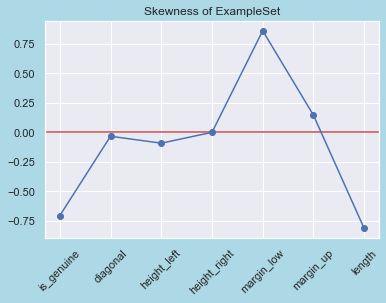

In [14]:
# graphique skewness
plt.figure(facecolor='lightblue')
plt.title('Skewness of ExampleSet')
plt.xticks(rotation=45)
plt.axhline(y=0, color="r", linestyle='-')
plt.plot(ExampleSet.skew(), linestyle='-', marker='o')



***Une valeur négative indique une asymétrie vers la gauche, une valeur positive une asymétrie vers la droite, et une valeur proche de 0 une asymétrie faible/nulle.***

Pour les variables:

- diagonal
- height_left
- height_right
- margin_up

Le résultat est très proche de **0** la distribution des valeurs est donc l'asymétrie est globalement très faible.

Pour les variables:

- is_genuine
- margin_low
- length

Le résultat indique une légère asymétrie, et une probable correlation entre ces variables.

In [15]:
# Kurtosis

ExampleSet.kurt()

is_genuine     -1.501001
diagonal       -0.125284
height_left    -0.195271
height_right   -0.027232
margin_low      0.223886
margin_up      -0.245076
length         -0.280325
dtype: float64

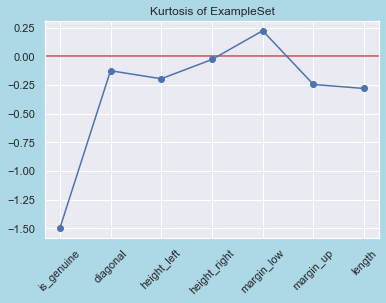

In [16]:
# graphique Kurtosis
plt.figure(facecolor='lightblue')
plt.title('Kurtosis of ExampleSet')
plt.xticks(rotation=45)
plt.axhline(y=0, color="r", linestyle='-')
plt.plot(ExampleSet.kurt(), linestyle='-', marker='o')

***un kurtosis inférieur à 3 est considéré comme "relativement plat" on parle de distribution platikurtique***

L'ensemble des valeurs de notre jeu de données suit cette distribution.

In [17]:
# nombre d'individus selon l'observation is_genuine:

print(f"Répartition des billets selon *is_genuine* \n{ExampleSet['is_genuine'].value_counts()}")

Répartition des billets selon *is_genuine* 
True     1000
False     500
Name: is_genuine, dtype: int64


<AxesSubplot:title={'center':'répartition du dataset selon is_genuine'}, xlabel='is_genuine', ylabel='count'>

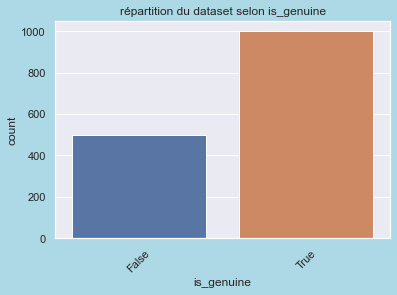

In [18]:
# Répartition selon le caractère is_genuine:
plt.figure(facecolor='lightblue')
plt.title('répartition du dataset selon is_genuine')
plt.xticks(rotation=45)
sns.countplot(ExampleSet['is_genuine'])


Nous avons donc 500 faux billets et 1000 vrai billets dans notre exemple de 1500 billets.

## Comparaison des variables

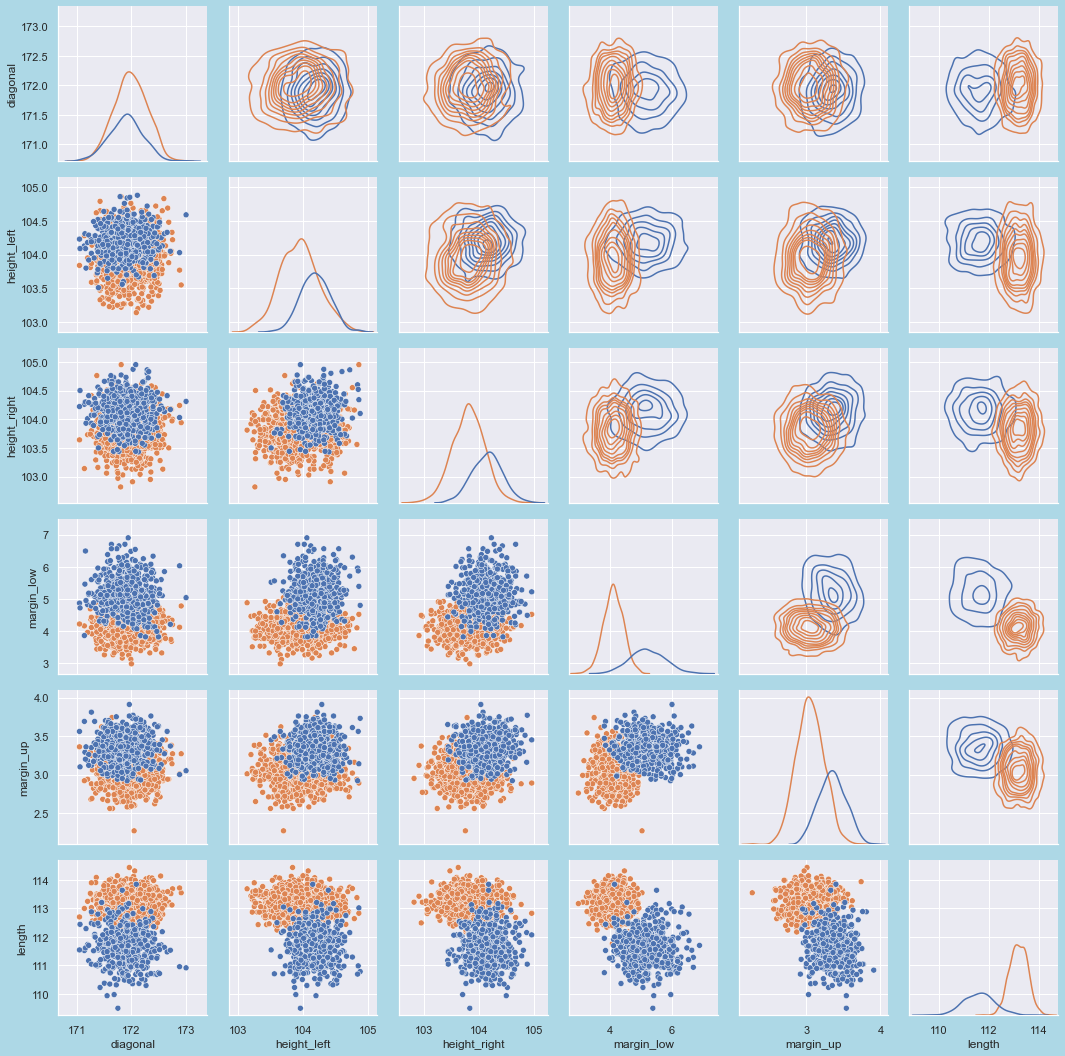

In [19]:
# graphique sns pairgrid sur l'ensemble des variables

g = sns.PairGrid(ExampleSet, hue="is_genuine")
g.map_lower(sns.scatterplot)
g.map_upper(sns.kdeplot)
g.map_diag(sns.kdeplot)


Dans chacun de ces graphiques, la distinction est faite entre is_genuine = True en orange, et is_genuine = False en bleu.

La Diagonale nous montre la répartition de chaque variable.

La partie du dessus nous montre la répartition du couple d'observation étudiée pour chaque individus

La partie du dessous affiche un point par couple d'observations étudiée pour chaque individus.

Cela nous permet de considérer rapidement que **margin_low** et **length** sont les deux observations sur lesquelles les differences entre is_genuine = True/False sont les plus marquées.


### Correlations

In [20]:
# Calcul de correlations

ExampleSet.corr()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
is_genuine,1.000000,0.132756,-0.379833,-0.485092,-0.783032,-0.606262,0.849285
diagonal,0.132756,1.000000,0.019472,-0.024492,-0.111534,-0.055649,0.097587
height_left,-0.379833,0.019472,1.000000,0.242279,0.302643,0.246522,-0.320863
height_right,-0.485092,-0.024492,0.242279,1.000000,0.391085,0.307005,-0.401751
margin_low,-0.783032,-0.111534,0.302643,0.391085,1.000000,0.431606,-0.666753
margin_up,-0.606262,-0.055649,0.246522,0.307005,0.431606,1.000000,-0.520575
length,0.849285,0.097587,-0.320863,-0.401751,-0.666753,-0.520575,1.000000


Text(0.5, 1.0, 'corrélations des variables')

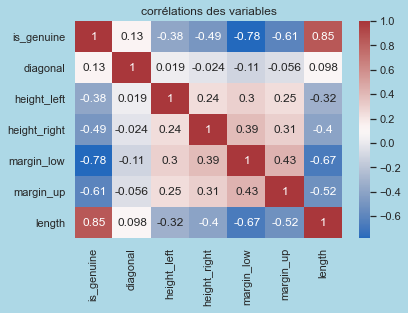

In [21]:
# Heatmap de correlations pour plus de lisibilité

sns.heatmap(ExampleSet.corr(), cmap="vlag", annot=True).set_title('corrélations des variables')

La matrice de correlation confirme nos hypothèses précédentes: 

- is_genuine est très fortement correlé à length (0.85)
- is_genuine est très fortement inversement correlé à margin_low (-0.78)

dans une moindre mesure:

- is_genuine est relativement inversement correlé à margin_up (-0.61)
- margin_low est relativement inversement correlé à length (-0.67) on s'en souviendra pour combler les nulls plus tard.

### Couples d'observations de fort interêt

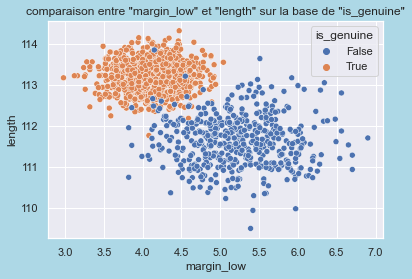

In [22]:
# Utilisation de la fonction scatter créée précédement

scatter(col1="margin_low", col2="length", title='comparaison entre "margin_low" et "length" sur la base de "is_genuine"' )

On remarque une forte distinction des valeurs du couple margin_low et length correspondant fortement à l'observation "is_genuine"

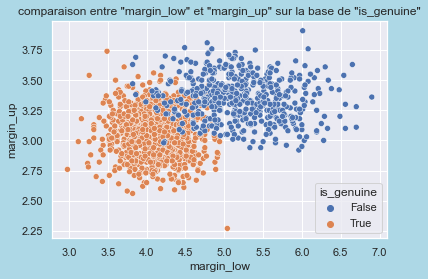

In [23]:
# Utilisation de la fonction scatter créée précédement

scatter(col1="margin_low", col2="margin_up", title='comparaison entre "margin_low" et "margin_up" sur la base de "is_genuine"' )

La séparation est très marquée aussi, mais moins nette que précédemment

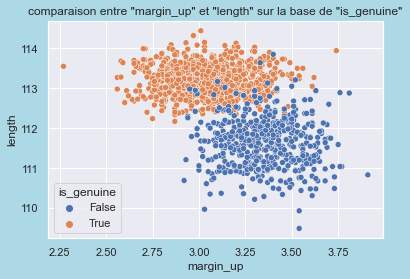

In [24]:
# Utilisation de la fonction scatter créée précédement

scatter(col1="margin_up", col2="length", title='comparaison entre "margin_up" et "length" sur la base de "is_genuine"' )

Ici aussi on distingue bien la séparation, mais elle reste plus faible que pour le premier couple étudié.

### Statistiques

#### Distributions

<function matplotlib.pyplot.show(close=None, block=None)>

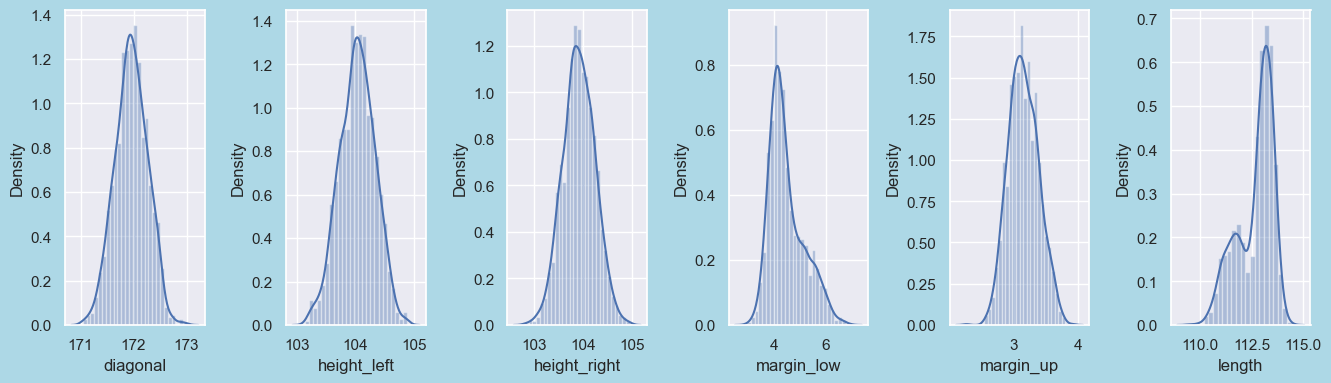

In [25]:
# forme globale des distributions

cols = ['diagonal', 'height_left','height_right','margin_low', "margin_up", "length"]
plt.figure(figsize=(20,4), dpi=100)
plt.title('distribution des variables')
i = 1
for col in cols:
    plt.subplot(1,9,i)
    sns.distplot(ExampleSet[col])
    i += 1
plt.tight_layout()
plt.show

On remarque des distributions qui semblent suivre la loi normale pour toutes les variables sauf pour length et margin_low

Vérifions cela avec des graphiques plus grands

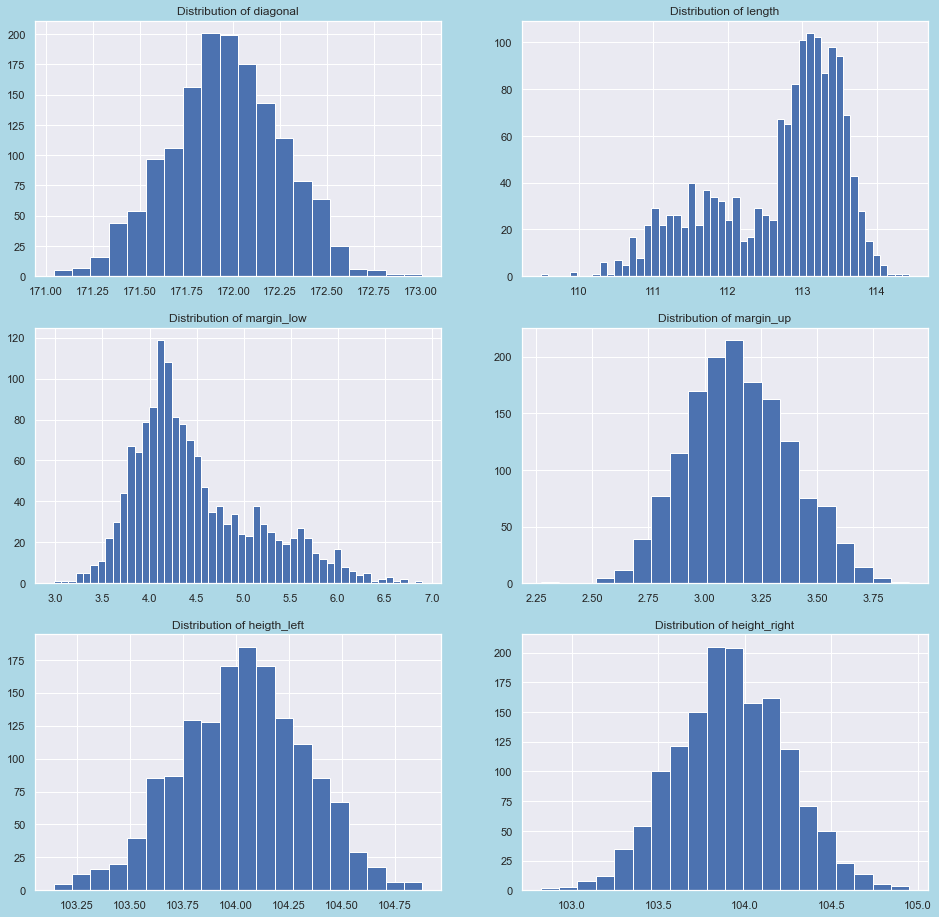

In [26]:
fig, axes = plt.subplots(3,2, figsize=(16,16))
axes[0,0].set_title("Distribution of diagonal")
axes[0,0].hist(ExampleSet['diagonal'], bins=20);
axes[0,1].set_title("Distribution of length")
axes[0,1].hist(ExampleSet['length'], bins=50);
axes[1,0].set_title("Distribution of margin_low")
axes[1,0].hist(ExampleSet['margin_low'], bins=50);
axes[1,1].set_title("Distribution of margin_up")
axes[1,1].hist(ExampleSet['margin_up'], bins=20);
axes[2,0].set_title("Distribution of heigth_left")
axes[2,0].hist(ExampleSet['height_left'], bins=20);
axes[2,1].set_title("Distribution of height_right")
axes[2,1].hist(ExampleSet['height_right'], bins=20);

Cette visualitation nous confirme que **length** et **margin_low** (pour lesquelles nous avons augmenté la précision de la représentation) ne suivent pas la loi normale. 

#### Distribution selon **is_genuine**

***Il convient de selectionner les observations les plus interressantes pour l'etablissement de notre algorithme "naif"***

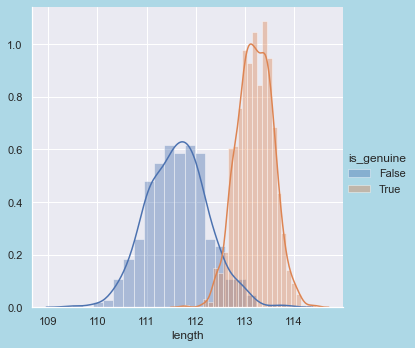

In [27]:
facet("length")

Les billets authentiques ont un longueur nettement plus importante que les contrefacons

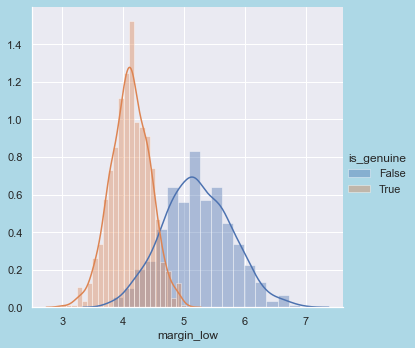

In [28]:
facet("margin_low")

les billets factices ont une marge inférieure plus grande que les authentiques

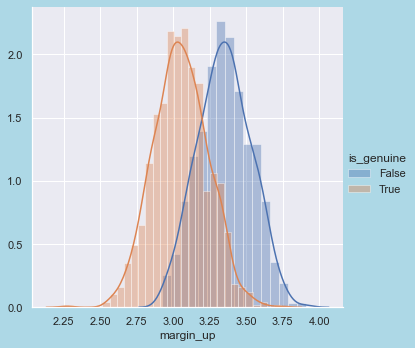

In [29]:
facet("margin_up")

Les billets authentiques ont une marge supérieure plus faible que les contrefacons, le chevauchement est cependant plus important que pour les deux valeurs précédentes.

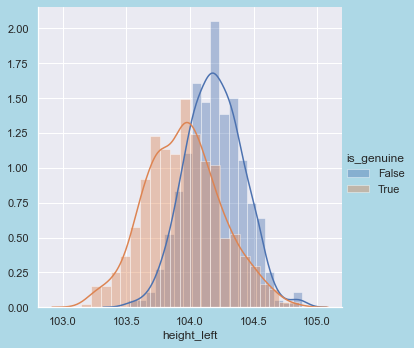

In [30]:
facet("height_left")

Pour la hauteur à gauche, le chevauchement est très important

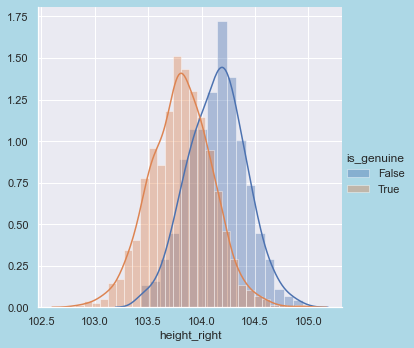

In [31]:
facet("height_right")

Pour la hauteur à droite le chevauchement aussi est très important

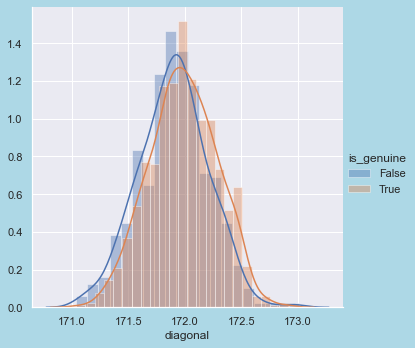

In [32]:
facet("diagonal")

Pour la diagonale le chevauchement est quasi parfait, trop important pour notre usage dans un algorithme naif.

#### Boxplot 5-95 quartiles

***Etude de la répartition des valeurs d'observation***

<AxesSubplot:xlabel='is_genuine', ylabel='margin_up'>

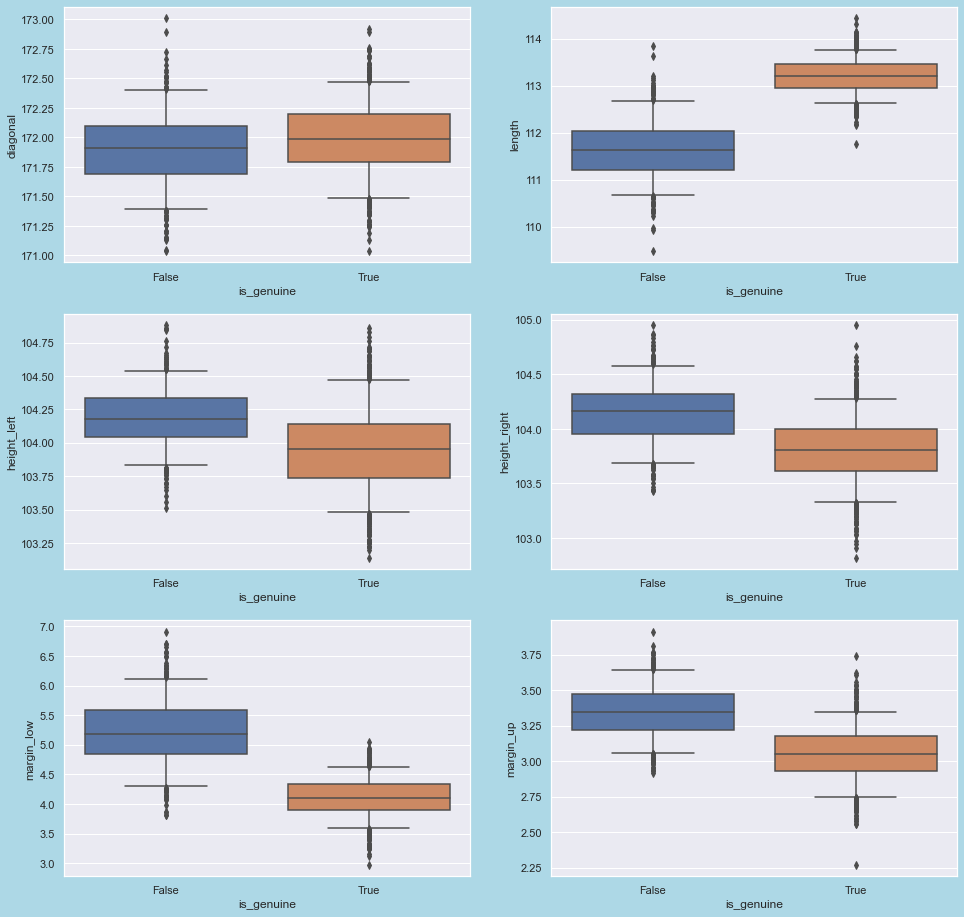

In [33]:
# boxplot[5,95] de toutes les variables avec sns
fig, axes= plt.subplots(3,2, figsize=(16,16))
sns.boxplot(y="diagonal", x="is_genuine", data=ExampleSet, orient='v', ax=axes[0,0], whis=[5,95])
sns.boxplot(y="length", x="is_genuine", data=ExampleSet, orient='v', ax=axes[0,1], whis=[5,95])
sns.boxplot(y="height_left", x="is_genuine", data=ExampleSet, orient='v', ax=axes[1,0], whis=[5,95])
sns.boxplot(y="height_right", x="is_genuine", data=ExampleSet, orient='v', ax=axes[1,1], whis=[5,95])
sns.boxplot(y="margin_low", x="is_genuine", data=ExampleSet, orient='v', ax=axes[2,0], whis=[5,95])
sns.boxplot(y="margin_up", x="is_genuine", data=ExampleSet, orient='v', ax=axes[2,1], whis=[5,95])

ici aussi on remarque que la marge inférieure et la longueur sont les deux valeurs distinguant le plus les contrefacons des originaux.

#### Violinplot des variables

<AxesSubplot:xlabel='is_genuine', ylabel='margin_up'>

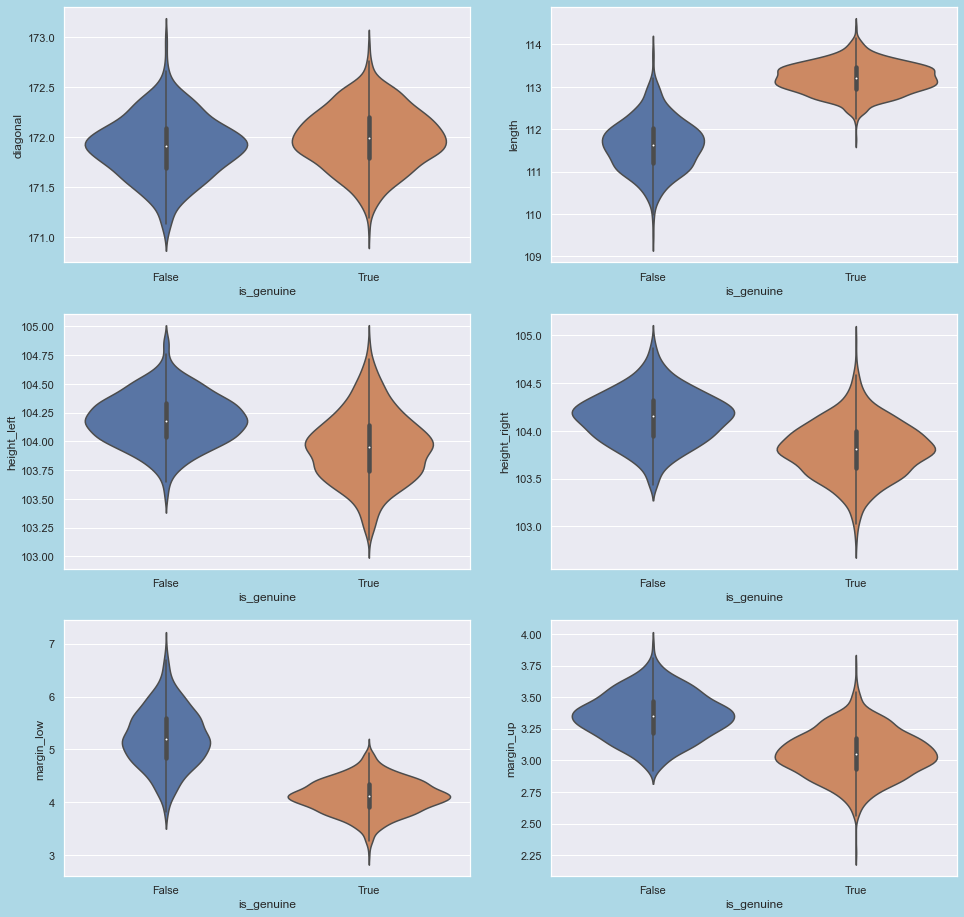

In [34]:
# Violinplot avec sns
fig, axes = plt.subplots(3,2, figsize=(16,16))
sns.violinplot(y="diagonal", x="is_genuine", data=ExampleSet, orient='v', ax=axes[0,0])
sns.violinplot(y="length", x="is_genuine", data=ExampleSet, orient='v', ax=axes[0,1])
sns.violinplot(y="height_left", x="is_genuine", data=ExampleSet, orient='v', ax=axes[1,0])
sns.violinplot(y="height_right", x="is_genuine", data=ExampleSet, orient='v', ax=axes[1,1])
sns.violinplot(y="margin_low", x="is_genuine", data=ExampleSet, orient='v', ax=axes[2,0])
sns.violinplot(y="margin_up", x="is_genuine", data=ExampleSet, orient='v', ax=axes[2,1])

Ce graphique nous permet d'établir une représentation plus précise de la répartition des valeurs.

n y remarque notemment que pour margin_low et length, la répartition est bien plus concentrée autour de la valeur médiane pour les billets authentiques que pour les contrefacons.

# Algorithme naif de reconnaissance des billets

***point de référence pour les algorithmes ML***

En étudiant les graphiques précédents, on peut déduire que si:

- La longueur d'un billet est supérieure à la valeur du 5eme quartile de la longueur des vrais billets

et dans le même temps:

- La marge basse d'un billet est inférieure à la valeur du 95 quartile de la marge basse des vrais billets

Il sagit très probablement d'un vrai billet.

## détermination des valeurs seuils

In [35]:
print(f'longueur minimale : {round(longueur_mini,2)}, marge inférieure maximale: {margin_low_max}')

longueur minimale : 112.65, marge inférieure maximale: 4.63


## test de l'algorithme naif

### sur les données exemple

In [36]:
print(
    f"sur un total de {notnullset.shape[0]} dont {real_true} vrai billets et {real_fake} contrefacons ")
print(
    f'nombre de billets reconnus vrais : {tested_true} - {fake_true} / {notnulltrue.shape[0]}')
print(
    f'cet algorithme simple reconnait {round((tested_true)*100/real_true,2)}% de vrais billets')
print(f"avec un taux d'erreur de {round(fake_true*100/tested_true,2)} %")
print(
    f"il ignore donc {tested_false}/{real_fake} faux billets dans le pool de départ dont {fake_false} qui sont bien réels ")
print(
    f"il ignore donc {round(fake_false*100/test_pool,2)}%  de vrai billets sur l'ensemble du set")
print(
    f"quand l'algorithme nous dit qu'un billet est faux, il y'a {round(fake_false*100/tested_false,2)}% de chances qu'en réalité il soit Vrai.")

sur un total de 1463 dont 971 vrai billets et 492 contrefacons 
nombre de billets reconnus vrais : 878 - 4 / 971
cet algorithme simple reconnait 90.42% de vrais billets
avec un taux d'erreur de 0.46 %
il ignore donc 585/492 faux billets dans le pool de départ dont 93 qui sont bien réels 
il ignore donc 6.36%  de vrai billets sur l'ensemble du set
quand l'algorithme nous dit qu'un billet est faux, il y'a 15.9% de chances qu'en réalité il soit Vrai.


Nous avons un algorithme naïf très simple de compréhension qui nous permet de reconnaitre efficacement les faux billets.

Néanmoins il est moins performant pour les vrais billets dont il considère un trop grand nombre d'entre eux comme faux.

Il conviendra donc de le comparer a d'autres algorithmes plus précis.

### Déploiement de l'algorithme naïf sur les billets à tester

***prédictions sur le set de billets à tester***

Pour vérifications du principe.

In [37]:
Naive_test

,diagonal,height_left,height_right,margin_low,margin_up,length,id,valid_length,valid_margin_low,Naive
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,0,0,False
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,0,0,False
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,0,0,False
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,1,1,True
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,1,1,True


Comme indiqué plus haut, on crée deux booleens de contrôle valid_length et valid_margin_low, si la somme des deux colonnes est = 2, notre billet est vrai, sinon, il est faux.

Reste à supprimer les colonnes de contrôle

In [38]:
# drop de colonnes
Naive_test.drop(columns=['valid_length', 'valid_margin_low'], inplace=True)
Naive_test

,diagonal,height_left,height_right,margin_low,margin_up,length,id,Naive
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,False
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,False
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,False
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,True
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,True


On reproduira le processus dans une fonction au cas ou on aurait besoin de reproduire l'algorithme de reconnaissance naif sur un autre DataFrame.

In [39]:
# Utilisation de la fonction de reconnaissance naïve

function_naive_test = naive_recon(ToTestSample)

In [40]:
# Export csv et affichage
function_naive_test.to_csv('tested.csv', index=False)
function_naive_test

0    False
1    False
2    False
3     True
4     True
Name: Naive, dtype: bool

# Remplacer les "null" de notre fichier d'exemple

## Calcul géométrique ou méthode naïve

***la solution la plus evidente est peut etre la meilleure?***

### Calcul des moyennes et médianes de la hauteur de l'imprimé 
***avec et sans distinction de l'authenticité***

In [41]:
print(f'overall printed_mean: {round(printedmean_h,2)}, overall printed_median: {round(printedmedian_h,2)}')
print(f'false printed_mean: {round(falseprintedmean_h,2)}, false printed_median: {round(falseprintedmedian_h,2)}')
print(f'true printed_mean: {round(trueprintedmean_h,2)}, true printed_median: {round(trueprintedmedian_h,2)}')



overall printed_mean: 96.34, overall printed_median: 96.49
false printed_mean: 95.6, false printed_median: 95.58
true printed_mean: 96.71, true printed_median: 96.7


On confirme que la hauteur de l'imprimé est plus grand sur les billets authentiques que sur les contrefaçons.

Il convient donc de comparer les résultats des calculs géométriques sur l'ensemble des billets à ceux obtenus en distinguant les billets selon leur authenticité.

### sans distinction de l'authenticité

<AxesSubplot:xlabel='is_genuine', ylabel='diff_h'>

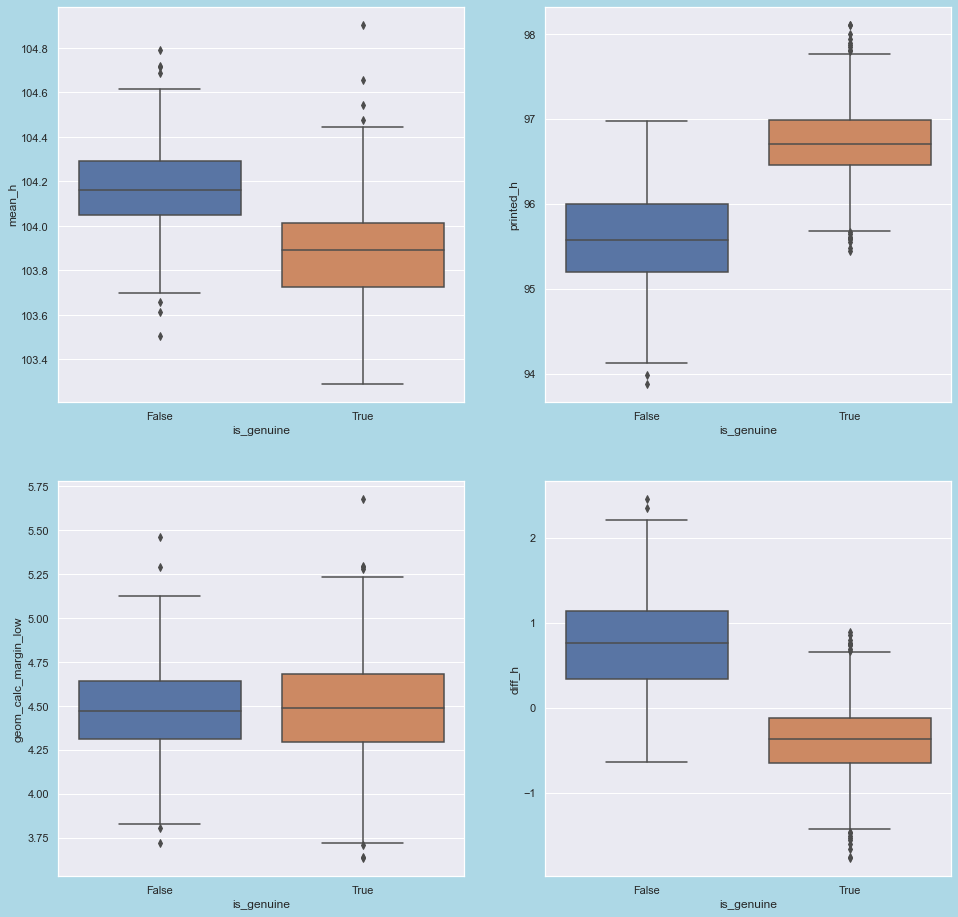

In [42]:
# sns boxplot sur notnullset
fig, axes= plt.subplots(2,2, figsize=(16,16))
sns.boxplot(y="mean_h", x="is_genuine", data=notnullset, orient='v', ax=axes[0,0])
sns.boxplot(y="printed_h", x="is_genuine", data=notnullset, orient='v', ax=axes[0,1])
sns.boxplot(y="geom_calc_margin_low", x="is_genuine", data=notnullset, orient='v', ax=axes[1,0])
sns.boxplot(y="diff_h", x="is_genuine", data=notnullset, orient='v', ax=axes[1,1])

Ces graphiques nous montrent en fonction de is_genuine:

- la moyenne de hauteur calculée
- la hauteur calculée de l'imprimé
- la marge basse calculée
- la difference de hauteur calculée dans les billets.

Compte tenu du caractère important de la margin_low dans la determination de l'authenticité d'un billet, cette méthode n'est pas convainquante.

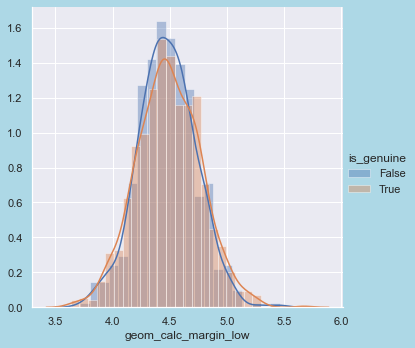

In [43]:
# Affichage du chevauchement de la valeur geom_calc_margin_low
sns.FacetGrid(notnullset, hue="is_genuine", height=5).map(sns.distplot, "geom_calc_margin_low").add_legend();

On observe le chevauchement de la valeur calculée de la marge basse à titre de comparaison pour la suite.

### Avec distinction de l'autenthicité

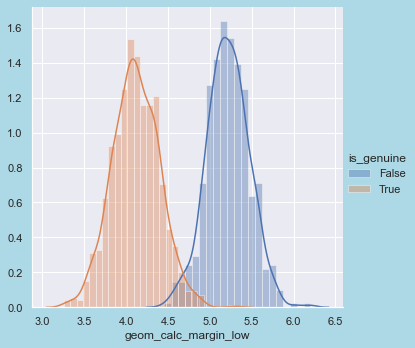

In [44]:
# Affichage du chevauchement de la valeur geom_calc_margin_low 
sns.FacetGrid(reunitedset, hue="is_genuine", height=5).map(sns.distplot, "geom_calc_margin_low").add_legend();

Cette méthode parait nous donner de bien meilleurs résultats, affichons les violinplot des valeurs calculées.

<AxesSubplot:xlabel='is_genuine', ylabel='diff_h'>

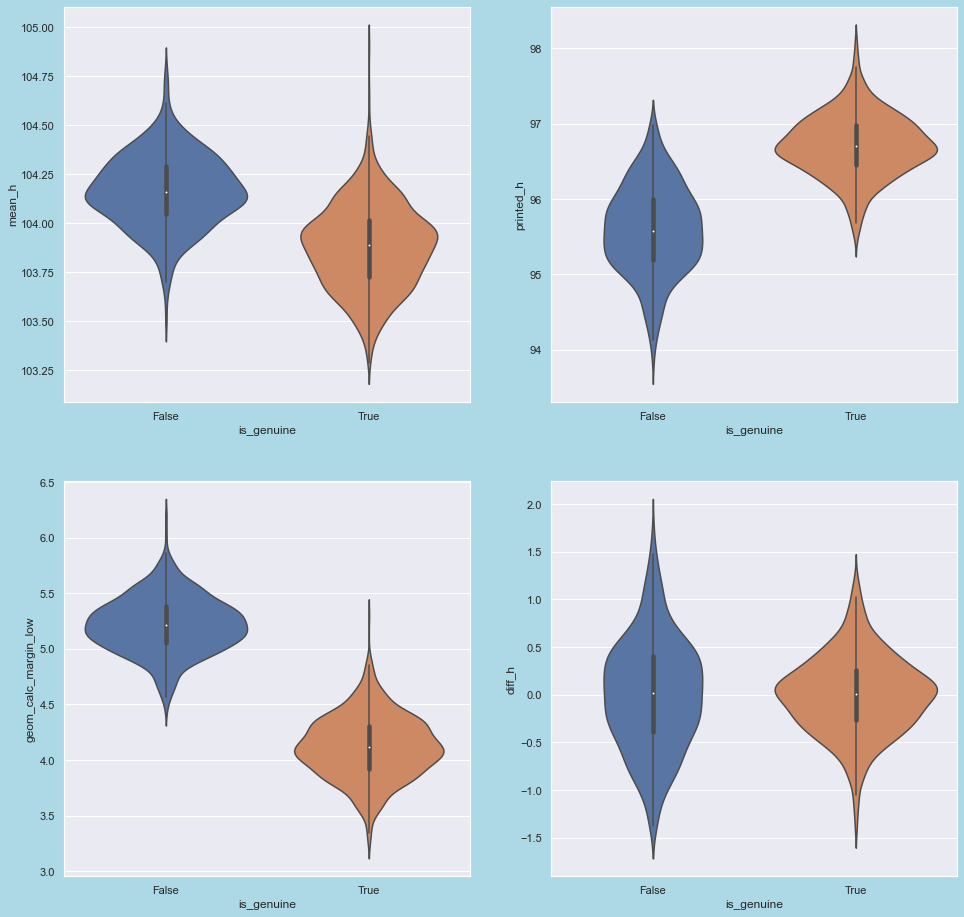

In [45]:
# sns violinplot, remplacer par boxplot si nécessaire
fig, axes= plt.subplots(2,2, figsize=(16,16))
sns.violinplot(y="mean_h", x="is_genuine", data=reunitedset, orient='v', ax=axes[0,0])
sns.violinplot(y="printed_h", x="is_genuine", data=reunitedset, orient='v', ax=axes[0,1])
sns.violinplot(y="geom_calc_margin_low", x="is_genuine", data=reunitedset, orient='v', ax=axes[1,0])
sns.violinplot(y="diff_h", x="is_genuine", data=reunitedset, orient='v', ax=axes[1,1])

Ce graphique nous montre des résultats plus proche de ce que nous attendions, néanmoins elle possède une faiblesse qui nous poussera à chercher une autre solution.

Il est impossible par cette méthode de calculer une marge basse "correcte" sans savoir si le billet est vrai ou faux.

Ce ne serait pas un gros problème pour notre usage immédiat, mais si dans le futur nous devons tester l'authenticité de billets dont nous ignorons la dimension de la marge basse il nous sera impossible de le faire.

## Regressions linéaires (méthode des moindres carrés)

***prédire un label en fonction de features***

On cherche à établir une relation linéaire entre une variable, dite expliquée (label, X), et une ou plusieurs variables, dites explicatives (features, y).

In [46]:
# préparatifs

# préparation d'un dataframe sans null
exemple_pool = ExampleSet[ExampleSet['margin_low'].isnull()==False]

# préparations de variables
m = exemple_pool.shape[0]
n = exemple_pool.shape[1]

# préparation des label

y = exemple_pool['margin_low'].values.reshape(m,1)
X3 = exemple_pool.drop(columns=['margin_low'])
X2 = exemple_pool.drop(columns=['margin_low', 'is_genuine'])
X = exemple_pool['length'].values.reshape(m,1)

###  Sur l'ensemble des valeurs

In [47]:
LRTotal = LinearRegression()
LRTotal.fit(X3,y)
LRTotal.score(X3,y)

0.6168760755671029

En prenant en compte l'intégralité des valeurs (!!!dont l'authenticité des billets!!!) le score est assez encourageant.

Néanmoins cette méthode ne nous permet pas de nous passer de la connaissance de l'authenticité des billets, elle est donc à proscrire.

### Sur l'ensemble des valeurs sauf is_genuine

In [48]:
LRMinusGenuine = LinearRegression()
LRMinusGenuine.fit(X2,y)
LRMinusGenuine.score(X2,y)

0.4773366973063955

Le score est nettement moins bon dès que l'on retire les informations d'authenticité. Mais c'est une obligation pour des raisons de reproductibilité.

### Sur la valeur la plus fortement corrélée

***Nous avions vu précédemment que la marge basse est fortement anti-corréllée à la longueur du billet***

Pour rappel, voici le graphe de la répartition des billets en fonction de margin_low et length

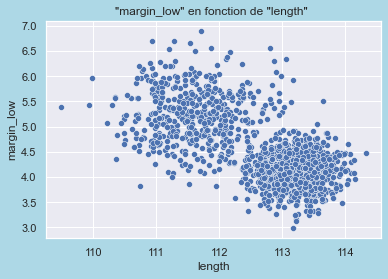

In [49]:
scatter2(col1="length", col2="margin_low", title='"margin_low" en fonction de "length" ' )

étudions les variables en présence

In [50]:

ax = exemple_pool["length"]
ay = exemple_pool['margin_low']
print('coefficient de correlation de pearson :', st.stats.pearsonr(ax,ay)[0])
print('indice de covariation :', np.cov(ax, ay, ddof=0)[1,0])

coefficient de correlation de pearson : -0.6667527808936011
indice de covariation : -0.3862227830808613


#### Variance Inflation Factor
Les FIV estiment de combien la variance d'un coefficient est augmentée en raison d'une relation lineaire avec les autres prédicteurs.

In [51]:
calculate_vif(df=exemple_pool, features=[
    "is_genuine", 
    "diagonal", 
    "height_left", 
    "height_right", 
    "margin_low", 
    "margin_up", 
    "length"] )

,VIF,Tolerance
is_genuine,6.446913,0.155113
diagonal,1.028293,0.972485
height_left,1.174137,0.851690
height_right,1.321281,0.756841
margin_low,2.610122,0.383124
margin_up,1.610467,0.620938
length,3.613323,0.276754


on retire "is_genuine" notre label.

In [52]:
calculate_vif(df=exemple_pool, features=[ 
    "diagonal", 
    "height_left", 
    "height_right", 
    "margin_low", 
    "margin_up", 
    "length"] )

,VIF,Tolerance
diagonal,1.018610,0.981730
height_left,1.151474,0.868452
height_right,1.260286,0.793471
margin_low,1.913278,0.522663
margin_up,1.419672,0.704388
length,2.131067,0.469249


on retire "diagonal", "height_left" et "height_right" dont le VIF est trop faible pour indiquer une relation.

In [53]:
calculate_vif(df=exemple_pool, features=[  
                                         "margin_low",
                                         "margin_up", 
                                         "length"
                                        ])

,VIF,Tolerance
margin_low,1.832432,0.545723
margin_up,1.397292,0.715670
length,2.047022,0.488515


Toutes les FIV restantes sont faibles, il n'existe donc pas de problème potentiel de colinéarité

#### mise en place du modèle

In [54]:
LR = LinearRegression()
LR.fit(X,y)
LR.score(X,y)

0.4445592708293492

In [55]:
margin_predict = LR.predict(exemple_pool['length'].values.reshape(exemple_pool.shape[0],1))
#Coefficients
print("Coefficients : ", LR.coef_)

#Mean squared error
print("Mean squared error: %.2f" % mean_squared_error(exemple_pool['margin_low'], margin_predict))
#Coefficient of determination
print("R2: %.2f " % r2_score(exemple_pool['margin_low'], margin_predict))
# RMSE
print('RMSE: %.2f' % np.sqrt(mean_squared_error(exemple_pool['margin_low'], margin_predict)))

Coefficients :  [[-0.50685746]]
Mean squared error: 0.24
R2: 0.44 
RMSE: 0.49


Ces résultats sont assez faibles, ils indiquent une modélisation de faible qualité.

Cherchons à comprendre pourquoi?

#### projection de la prédiction sur le nuage de points

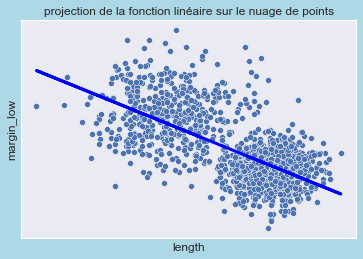

In [56]:
#sns.scatterplot(ExampleSet,'length'], ExampleSet['margin_low'])
scatter2(col1="length", col2="margin_low", title='comparaison entre "margin_low" et "length" sur la base de "is_genuine"' )
plt.plot(exemple_pool['length'], margin_predict, color="blue", linewidth=3)

plt.xticks(())
plt.yticks(())
plt.title('projection de la fonction linéaire sur le nuage de points')
plt.show()

On remarque immédiatement que la ligne est très fine comparé au "faisceau de points" qui nous sert de modèle.

#### normalité des résidus 

In [57]:
residus = LR._residues
residus

array([357.82947385])

In [58]:
exemple_pool['predict_margin_low'] = margin_predict

In [59]:
exemple_pool['residus'] = exemple_pool['margin_low']-exemple_pool['predict_margin_low']

Text(0.5, 0.98, 'répartition des résidus')

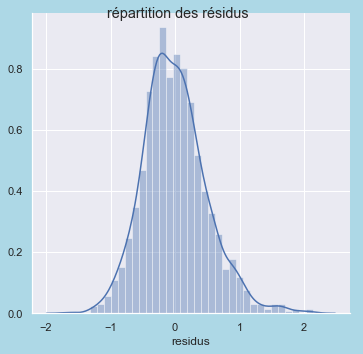

In [60]:
rp = sns.FacetGrid(exemple_pool, height=5).map(sns.distplot, "residus").add_legend()
rp.fig.suptitle('répartition des résidus')

Graphiquement, les résidus (différence entre le modèle et la prédiction) semblent suivre la loi normale.

Text(0.5, 1.0, 'résidus en fonction de length')

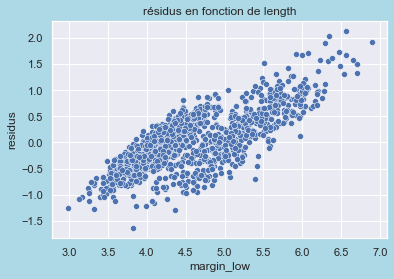

In [61]:
sns.scatterplot(data=exemple_pool, x="margin_low", y='residus').set_title('résidus en fonction de length')

In [62]:
is_normal = exemple_pool[['length', 'residus','margin_low']]
is_normal = is_normal[is_normal['residus'].isnull()==False]
is_normal.describe(include='all')

,length,residus,margin_low
count,1463.000000,1.463000e+03,1463.000000
mean,112.674757,3.243703e-15,4.485967
std,0.873222,4.947256e-01,0.663813
min,109.490000,-1.646613e+00,2.980000
25%,112.020000,-3.333755e-01,4.015000
50%,112.960000,-4.001833e-02,4.310000
75%,113.340000,2.876561e-01,4.870000
max,114.320000,2.137513e+00,6.900000


on remarque que la majorité des pointsont une valeur résiduelle comprise entre -0.5 et 0.5, mais il y'a quelques outliers au dela des |1.5|, nous verrons s'il est nécessaire de les filtrer. 

In [63]:
# Réduction de l'ecart des résidus pour éliminer les outliers > |1.5|
#reduced_is_normal = is_normal[np.abs(is_normal['residus']) >= 1.5]

In [64]:
is_normal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1463 entries, 0 to 1499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   length      1463 non-null   float64
 1   residus     1463 non-null   float64
 2   margin_low  1463 non-null   float64
dtypes: float64(3)
memory usage: 45.7 KB


In [65]:
from scipy.stats import shapiro
test_shapiro = shapiro(is_normal['residus'])
print(test_shapiro)

ShapiroResult(statistic=0.9824789762496948, pvalue=2.3925759377180222e-12)


Le test de shapiro indique que les résidus ne suivent pas la loi normale, mais 5% du temps il rejette des séries normales, il convient donc d'appliquer d'autres tests en compléments.

In [66]:
from scipy.stats import anderson
test_anderson = anderson(is_normal['residus'], 'norm')
print(test_anderson)

AndersonResult(statistic=5.320705569169377, critical_values=array([0.574, 0.654, 0.785, 0.916, 1.089]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))


In [67]:
from scipy.stats import kstest
test_kstest = kstest(is_normal['residus'], 'norm')
print(test_kstest)

KstestResult(statistic=0.18483989273654017, pvalue=3.1758278817528347e-44)


Nos résidus ne suivent donc pas la loi normale même s'ils en sont graphiquement très proches.

C'est un résultat attendu compte tenu de la faible qualité de représentation de la regression sur ces données.

#### homoscedasticité (uniformité de la variance de l'erreur)

L'homoscédasticité peut être vérifiée avec le test de Levene (non sensible à la non-normalité - à privilégier), de Barlett (à privilégier si la distribution est normale) ou de Fisher (moins robuste en l'absence de normalité - déconseillé).

Nos résidus ne suivant pas la loi normale, nous faisons le test de levene.

In [68]:
from scipy.stats import levene
test_levene = levene(is_normal['residus'],is_normal['margin_low'])
print(test_levene)
test_levene.pvalue

LeveneResult(statistic=76.04877612763872, pvalue=4.557393276701637e-18)


4.557393276701637e-18

Nos résidus présentent un caractère d'heteroscedasticité, certainement dus à la faible qualité de représentation de la regression lineaire.

### Sur la valeur la plus fortement correlée, centré-réduite

In [69]:
X1 = sc.fit_transform(X)
LRCentered = LinearRegression()
LRCentered.fit(X1,y)
LRCentered.score(X1,y)

0.4445592708293492

Le centrage et la réduction de nos données en entrées n'améliore pas significativement le score de la regression lineaire, nous choisirons donc le modèle le plus simple pour imputer nos données.

### Imputation des données

***Remplir les trous***



In [70]:
# Préparations des données
cheese_data = ExampleSet[ExampleSet['margin_low'].isnull()==True]
cheese_data.drop(columns=['margin_low'], inplace=True)
cheese_data.head()

,is_genuine,diagonal,height_left,height_right,margin_up,length
72,True,171.94,103.89,103.45,3.25,112.79
99,True,171.93,104.07,104.18,3.14,113.08
151,True,172.07,103.80,104.38,3.02,112.93
197,True,171.45,103.66,103.80,3.62,113.27
241,True,171.83,104.14,104.06,3.02,112.36


On récupère la liste des billets pour lesquels margin_low est nulle. et on supprime l'ancienne colonne margin_low

In [71]:
# préparation des variables
m2 = cheese_data.shape[0]
X4 = cheese_data['length'].values.reshape(m2,1)

# imputation par régréssion linéaire
cheese_data['margin_low'] = LR.predict(X4)

on crée une nouvelle colonne margin low, et on la remplis avec les prédictions de notre regression lineaire.

In [72]:
# vérifications
cheese_data.head()

,is_genuine,diagonal,height_left,height_right,margin_up,length,margin_low
72,True,171.94,103.89,103.45,3.25,112.79,4.427556
99,True,171.93,104.07,104.18,3.14,113.08,4.280567
151,True,172.07,103.80,104.38,3.02,112.93,4.356596
197,True,171.45,103.66,103.80,3.62,113.27,4.184264
241,True,171.83,104.14,104.06,3.02,112.36,4.645504


In [73]:
# concaténation des dataframes
exemple_pool = pd.concat([exemple_pool, cheese_data],axis=0)

# vérification du shape, attendu (1500, 7)
exemple_pool.shape

(1500, 9)

On concatène le df qu'on vient de remplir avec celui ou nous avions éliminé toutes les lignes contenant des valeurs nulles pour obtenir un dataframe complet.

In [74]:
# export en csv

exemple_pool.to_csv('DataStore/TrainingData.csv')

On peut exporter le dataframe complété pour d'éventuelles analyses futures avec d'autres outils.

# Reconnaissance des billets par méthode de l'ACP

L'ACP est une méthode de synthèse de l'information qui sert à décrire un jeu de données comportant de nombreux individus et variables quantitatives. L'analyse permet d'extraire l'information pertinente et la synthétise sous la forme de composantes principales, nouveaux axes pour décrire le jeu de données.

In [75]:
# Import des fichiers (inutile dans le même notebook)
#FullTrainingSet = pd.read_csv('DataStore/TrainingData.csv')
#TestSample = pd.read_csv('DataStore/tested.csv')

# renommage des Dataframes
FullTrainingSet = exemple_pool
TestSample = Naive_test


## Choix des données pour l'ACP

On à vu précédemment que la diagonale est très peu différenciée quelque soit l'authenticité des billets.

In [76]:
# choix des données pour l'ACP
X = FullTrainingSet[['diagonal','height_left', 'height_right', 'margin_low', 'margin_up', 'length']]

# préparation des données pour l'ACP
XX = X.values
names = X.index
features = X.columns
N = X.shape[0]
p = X.shape[1]

# Centrage et Réduction
X_scaled = sc.fit_transform(XX)

#Calcul des composantes principales
acp = PCA()
Z = acp.fit(X_scaled)
print(f'score: {acp.score(X_scaled)}')
#print(f'score sample: {acp.score_samples(X_scaled)}')
print(f'nombre de composantes {acp.n_components_}')
#print(f'variance expliquée {acp.explained_variance_}')
n_comp = acp.n_components_

score: -7.858262453514231
nombre de composantes 6


On a choisi de faire une analyse en composantes principales sur les 6 variables du dataframe autres que is_genuine


## Eboulis des valeurs propres

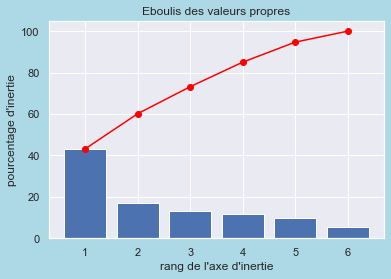

In [77]:
# Eboulis des valeurs propres
display_scree_plot(acp)

Le graphique d'eboulis nous montre que la majorité (60%) des informations est contenu dans les deux premières composantes. Nous limiterons donc notre étude à ces deux dimensions.

## corrélations de chaque variables à chaque composante

In [78]:
# Variance expliquée:
eigval = acp.explained_variance_

#racine carrée des valeurs propres
sqrt_eigval = np.sqrt(eigval)

#corrélation des variables avec les axes
corvar = np.zeros((p,p))
for k in range(p):
    corvar[:,k] = acp.components_[k,:] * sqrt_eigval[k]

#afficher la matrice des corrélations variables x facteurs
print(corvar)

[[-0.13596526  0.94959634 -0.25596556 -0.08660508 -0.08611685  0.00352646]
 [ 0.53270335  0.31043488  0.78288223 -0.04524097  0.07451214  0.00458721]
 [ 0.63311896  0.10988266 -0.13832823  0.7348913   0.1689243   0.00423704]
 [ 0.81653828 -0.07331037 -0.10033266 -0.08527762 -0.43132803  0.35380101]
 [ 0.70837601 -0.00526914 -0.23853898 -0.36292325  0.54815114  0.0987875 ]
 [-0.85059316  0.04965139  0.13328044  0.14840269  0.22860778  0.42736937]]


Text(0.5, 1.0, 'Heatmap correlation variables/facteurs')

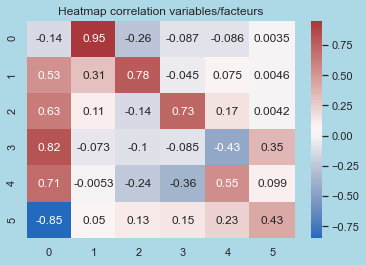

In [79]:
sns.heatmap(corvar,cmap="vlag", annot=True).set_title("Heatmap correlation variables/facteurs")

On confirme que chaque variable est correctement représentée dans les deux premieres composantes. les pertes éventuelles d'information ne devraient pas impacter nos résultats.

## vérifications de la qualité de représentation

In [80]:
#contribution des individus dans l'inertie totale
di = np.sum(X_scaled**2, axis=1)
print(pd.DataFrame({'ID':X.index, 'd_i':di}))

        ID        d_i
0        0  19.244817
1        1  10.193245
2        2  10.834669
3        3   7.011562
4        4   5.749532
...    ...        ...
1495  1303   8.112142
1496  1315   2.346855
1497  1347  17.660039
1498  1435  14.449038
1499  1438   4.864215

[1500 rows x 2 columns]


In [81]:
#qualité de représentation des individus - COS2
cos2 = X_scaled**2
for j in range(p):
    cos2[:,j] = cos2[:,j]/di

print(pd.DataFrame({'id':X.index,'COS2_1':cos2[:,0],'COS2_2':cos2[:,1]}))

        id    COS2_1    COS2_2
0        0  0.012300  0.399887
1        1  0.261847  0.490726
2        2  0.530663  0.208986
3        3  0.548733  0.022739
4        4  0.097509  0.121752
...    ...       ...       ...
1495  1303  0.059274  0.291654
1496  1315  0.067644  0.069001
1497  1347  0.034586  0.117083
1498  1435  0.365953  0.069721
1499  1438  0.007543  0.143911

[1500 rows x 3 columns]


In [82]:
#vérifions la théorie - somme en ligne des cos2 = 1
print(np.sum(cos2,axis=1))


[1. 1. 1. ... 1. 1. 1.]


In [83]:
#le champ components_ de l'objet ACP
print(acp.components_)

[[-0.08440101  0.33067785  0.39301126  0.50686958  0.4397274  -0.52800929]
 [ 0.941143    0.30767138  0.10890449 -0.07265776 -0.00522223  0.0492094 ]
 [-0.28939963  0.88514185 -0.15639658 -0.11343806 -0.26969681  0.15068945]
 [-0.10273638 -0.05366768  0.87177415 -0.10116166 -0.43052232  0.17604458]
 [-0.11304981  0.09781574  0.22175521 -0.56622546  0.71958487  0.30010464]
 [ 0.00625718  0.00813931  0.00751799  0.62776662  0.17528355  0.75830259]]


Text(0.5, 1.0, "heatmap des components de l'ACP")

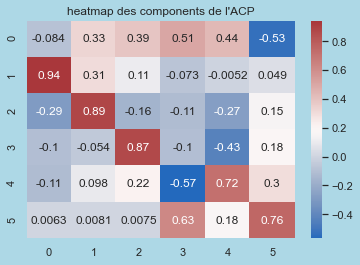

In [84]:
sns.heatmap(acp.components_,cmap="vlag", annot=True).set_title("heatmap des components de l'ACP")

In [85]:
#racine carrée des valeurs propres
sqrt_eigval = np.sqrt(eigval)

## Cercle des corrélations

In [86]:
#on affiche les corrélations pour les deux premiers axes
print(pd.DataFrame({'id':features,'COR_1':corvar[:,0],'COR_2':corvar[:,1]}))

             id     COR_1     COR_2
0      diagonal -0.135965  0.949596
1   height_left  0.532703  0.310435
2  height_right  0.633119  0.109883
3    margin_low  0.816538 -0.073310
4     margin_up  0.708376 -0.005269
5        length -0.850593  0.049651


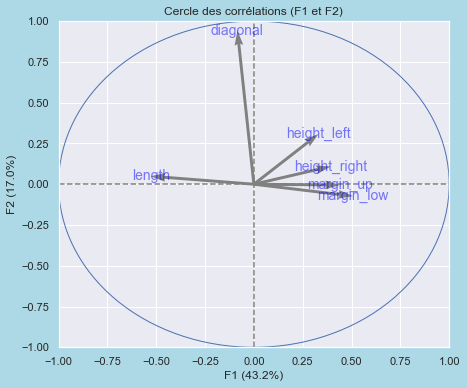

In [87]:
# Cercle des corrélations
pcs = acp.components_
display_circles(pcs, n_comp, acp, [(0,1)], labels = np.array(features))

Sur le cercle de correlation pour les axes 1 et 2 on devine que plus la longueur est importante plus l'individu sera à gauche
plus la marge_low sera importante plus l'individu sera à droite.

Les billets authentiques doivent donc se trouver sur la gauche et les factices à droite.

In [88]:
#cosinus carré des variables
cos2var = corvar**2
print(pd.DataFrame({'id':X.columns,'COS2_1':cos2var[:,0],'COS2_2':cos2var[:,1]}))

             id    COS2_1    COS2_2
0      diagonal  0.018487  0.901733
1   height_left  0.283773  0.096370
2  height_right  0.400840  0.012074
3    margin_low  0.666735  0.005374
4     margin_up  0.501797  0.000028
5        length  0.723509  0.002465


In [89]:
print(pd.DataFrame({'id':X.columns,'COR_1':corvar[:,0],'COR_2':corvar[:,1]}))

             id     COR_1     COR_2
0      diagonal -0.135965  0.949596
1   height_left  0.532703  0.310435
2  height_right  0.633119  0.109883
3    margin_low  0.816538 -0.073310
4     margin_up  0.708376 -0.005269
5        length -0.850593  0.049651


## projection des individus

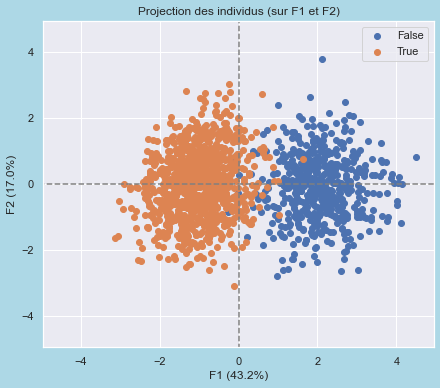

In [90]:
# Projection des individus
X_projected = acp.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, acp, [(0,1)], illustrative_var=FullTrainingSet['is_genuine'])
plt.show()

La projection des individus nous montre deux amas d'individus quasiment distincts, et globalement aux emplacements ou nous nous attendions à les trouver.

## ajout de nouveaux individus

In [91]:
# récupération des individus à tester
indSupp = TestSample
# mise en forme des données
indSupp = indSupp.drop(columns=["id","Naive"])
# Centrage Réduction
ZIndSupp = sc.transform(indSupp)
coord = acp.fit_transform(X_scaled)
#projection dans l'espace factoriel
coordSupp = acp.transform(ZIndSupp)

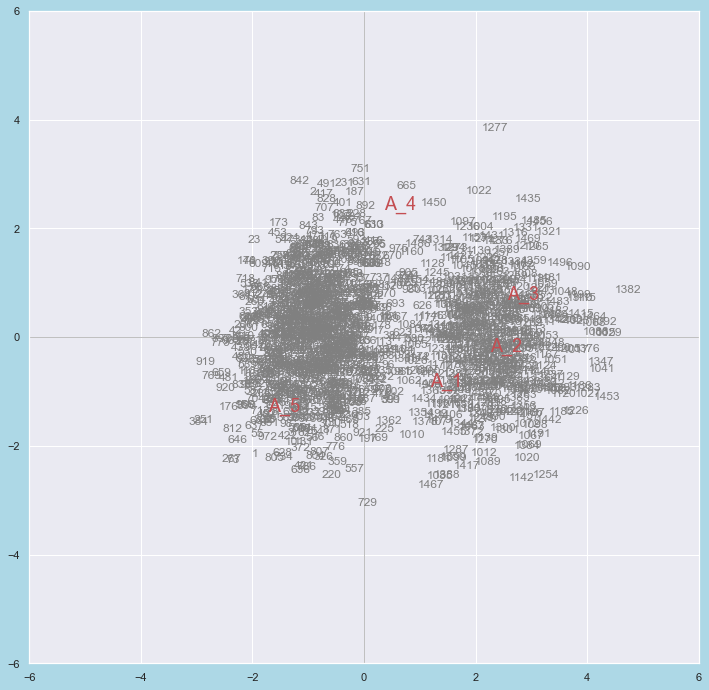

In [92]:
#positionnement des individus supplémentaires dans le premier plan
fig, axes = plt.subplots(figsize=(12,12))
axes.set_xlim(-6,6)
axes.set_ylim(-6,6)
#étiquette des points actifs
for i in range(N):
    plt.annotate(X.index[i],(coord[i,0],coord[i,1]), color='grey')

#étiquette des points supplémentaires (illustratifs) en rouge ‘r’
for j in range(coordSupp.shape[0]):
    plt.annotate(TestSample.id[j],(coordSupp[j,0],coordSupp[j,1]),color='r', fontsize='18')

#ajouter les axes
plt.plot([-6,6],[0,0],color='silver',linestyle='-',linewidth=1)
plt.plot([0,0],[-6,6],color='silver',linestyle='-',linewidth=1)
#affichage
plt.show()

Selon la méthode de l'ACP, on peut déterminer que A_1, A_2 et A_3 sont faux.

On détermine aussi que A_4 et A_5 sont vrais.

Mais cela demande une interprétation humaine alors que nous devons proposer une solution automatisée.

In [93]:
# On remplis les résultats de l'ACP manuellement pour comparer avec les autres méthodes.

TestSample["ACP"] = ['False', 'False', 'False', 'True', 'True']
TestSample

,diagonal,height_left,height_right,margin_low,margin_up,length,id,Naive,ACP
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,False,False
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,False,False
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,False,False
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,True,True
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,True,True


# préparation des données pour usage des algorithmes de Machine Learning

***Kmean, KNN et Regression logistique***

In [94]:
# On récupère le dataframe d'exemples complet.
FullTrainingSet

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,predict_margin_low,residus
0,True,171.81,104.86,104.95,4.520000,2.89,112.83,4.407281,0.112719
1,True,171.46,103.36,103.66,3.770000,2.99,113.09,4.275498,-0.505498
2,True,172.69,104.48,103.50,4.400000,2.94,113.16,4.240018,0.159982
3,True,171.36,103.91,103.94,3.620000,3.01,113.51,4.062618,-0.442618
4,True,171.73,104.28,103.46,4.040000,3.48,112.54,4.554270,-0.514270
...,...,...,...,...,...,...,...,...,...
1303,False,172.17,104.49,103.76,5.228390,2.93,111.21,NaN,NaN
1315,False,172.08,104.15,104.17,4.680984,3.40,112.29,NaN,NaN
1347,False,171.72,104.46,104.12,5.684562,3.61,110.31,NaN,NaN
1435,False,172.66,104.33,104.41,5.096607,3.56,111.47,NaN,NaN


Il va falloir préparer ce tableau en supprimant quelques colonnes inutiles et en le découpant en label (ce qu'on veut prédire) et en features (ce qu'on utilise pour prédire).

On va aussi en profiter pour le découper en un jeu de données d'apprentissage et de tests pour nos modèles.

In [95]:
# on distingue le label (ce qu'on veut prédire) des features (ce qu'on étudie pour prédire)
MLLabel = FullTrainingSet['is_genuine']
#MLLabel = MLLabel.values.reshape(MLLabel.shape[0],1)
MLfeatures = FullTrainingSet.drop(columns=['is_genuine', 'predict_margin_low',"residus"])

# on découpe notre jeu de données en un jeu d'entrainement et un jeu de tests
xtrain, xtest, ytrain, ytest = train_test_split(MLfeatures, MLLabel, train_size=0.5)

# On crée un Dataframe pour stoquer les résultats de nos differents algorithmes
ModelResults = pd.DataFrame(ytest, index=ytest.index)



## reconnaissance par algorithme naif

***Comme point de comparaison***

In [96]:
#on y applique notre algorithme naif
ModelResults["Naif"] = naive_recon(xtest)
xtest = xtest.drop(columns=['Naive'])
# on ajoute notre note maison
ModelResults['Naif-Note'] = np.where(ModelResults['is_genuine']==ModelResults['Naif'],1 ,0)

A titre d'etalon on crée un fichier de résultats pour comparer les résultats de chaque modèle, et on y inscrit les résultats de notre modèle naïf.

Text(0.5, 1.0, 'informations données dans le fichier')

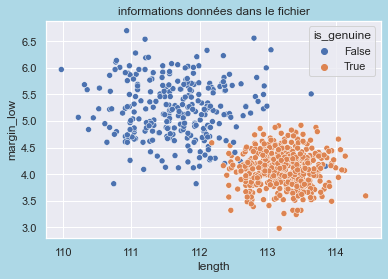

In [97]:
sns.scatterplot(xtest['length'],xtest['margin_low'], hue=ModelResults['is_genuine']).set_title('informations données dans le fichier')

On trace un graphique avec les données fournies aussi pour comparaison avec les résultats de nos modèles.

### Matrice de confusion

,Vrai,Faux
Vrai,272,1
Faux,45,432


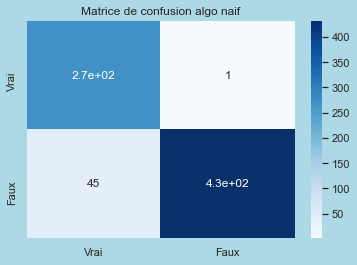

In [98]:
matrix_naif = confusion_matrix(ytest, ModelResults['Naif'])
sns.heatmap(matrix_naif, annot=True, xticklabels=["Vrai","Faux"], yticklabels=["Vrai","Faux"],cmap='Blues').set_title('Matrice de confusion algo naif')
matrix_naif=pd.DataFrame(matrix_naif, index=['Vrai', 'Faux'], columns=['Vrai', "Faux"])
matrix_naif

On remarque que notre algorithme naif est assez correct pour éliminer les faux billets, par contre, il manque de finesse pour la reconnaissance des originaux et en rejette un trop grand nombre.

Text(0.5, 1.0, 'predictions Naif')

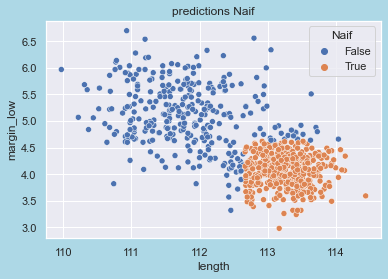

In [99]:
sns.scatterplot(xtest['length'],xtest['margin_low'], hue=ModelResults['Naif']).set_title('predictions Naif')

En comparant graphiquement avec les informations données, on ne peut que constatter le manque de précision.

# Reconnaissance par la méthode des Kmeans

C'est l'un des algorithmes de clustering les plus répandus. Il permet d'analyser un jeu de données caractérisées par un ensemble de descripteurs, afin de regrouper les données "similaires" en groupes appelés clusters.

Nous allons essayer plusieurs 'découpages' afin de choisir le meilleur pour notre étude.

Text(0.5, 1.0, 'swarmplot n=5')

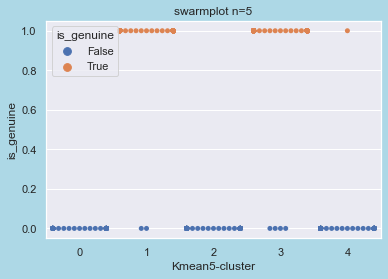

In [100]:
KmeanResults = ModelResults[['is_genuine',]]
KMeanModel_5 = KMeans(n_clusters=5).fit(xtrain, ytrain)
KmeanResults["Kmean5-cluster"] = KMeanModel_5.predict(xtest)
km5Score = KMeanModel_5.score(xtest, ytest)
KmeanResults
sns.swarmplot(x = KmeanResults['Kmean5-cluster'], y = KmeanResults['is_genuine'], hue=KmeanResults['is_genuine']).set_title("swarmplot n=5")

Le résultat (peu satisfaisant d'un découpage en n=5 clusters)

Text(0.5, 1.0, 'swarmplot n=4')

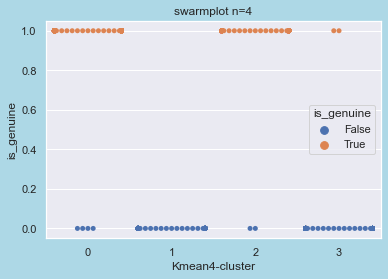

In [101]:
KMeanModel_4 = KMeans(n_clusters=4).fit(xtrain, ytrain)
KmeanResults["Kmean4-cluster"] = KMeanModel_4.predict(xtest)
km4Score = KMeanModel_4.score(xtest, ytest)
KmeanResults
sns.swarmplot(x = KmeanResults['Kmean4-cluster'], y = KmeanResults['is_genuine'], hue=KmeanResults['is_genuine']).set_title("swarmplot n=4")

Le résultat (peu satisfaisant d'un découpage en n=4 clusters)

Text(0.5, 1.0, 'swarmplot n=3')

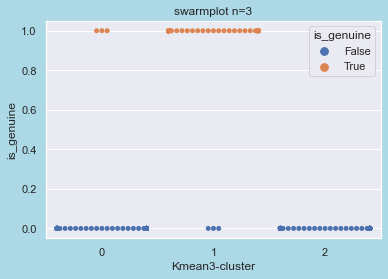

In [102]:
KMeanModel_3 = KMeans(n_clusters=3).fit(xtrain, ytrain)
KmeanResults["Kmean3-cluster"] = KMeanModel_3.predict(xtest)
km3Score = KMeanModel_3.score(xtest, ytest)
KmeanResults
sns.swarmplot(x = KmeanResults['Kmean3-cluster'], y = KmeanResults['is_genuine'], hue=KmeanResults['is_genuine']).set_title("swarmplot n=3")

Le résultat d'un découpage en 3 clusters.
Les clusters 0 et 2 correspondant quasi exclusivement à des contrefaçons, et le cluster 1 quasi exclusivement à des originaux.

In [103]:
KMeanModel_1 = KMeans(n_clusters=1).fit(xtrain, ytrain)
KmeanResults["Kmean1-cluster"] = KMeanModel_1.predict(xtest)
km1Score = KMeanModel_1.score(xtest, ytest)
#KmeanResults
#sns.swarmplot(x = KmeanResults['Kmean3-cluster'], y = KmeanResults['is_genuine'], hue=KmeanResults['is_genuine'])

On calcule n_clusters = 1 dans le but de tracer une courbe du coude.

Text(0.5, 1.0, 'swarmplot n=2')

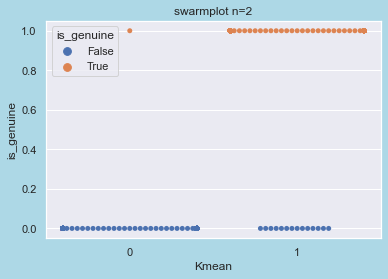

In [104]:
KMeanModel = KMeans(n_clusters=2).fit(xtrain, ytrain)
ModelResults["Kmean"] = KMeanModel.predict(xtest)
KMeanModel.score(xtest, ytest)
KmeanResults["Kmean"] = KMeanModel.predict(xtest)
kmScore = KMeanModel.score(xtest, ytest)
KmeanResults
sns.swarmplot(x = KmeanResults['Kmean'], y = KmeanResults['is_genuine'], hue=KmeanResults['is_genuine']).set_title("swarmplot n=2")

Nous utiliserons le modèle à deux clusters, plus simple à mettre en place.

Text(0.5, 1.0, 'Elbow Curve')

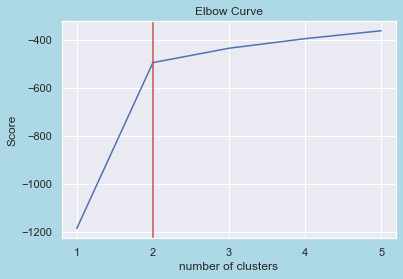

In [105]:
elbow = pd.DataFrame(columns=['n_clusters','score'])
elbow['n_clusters'] = [1, 2, 3 , 4, 5]
elbow['score'] = [km1Score, kmScore, km3Score, km4Score,km5Score]

plt.plot(elbow['n_clusters'],elbow['score'])
plt.axvline(x=2, color='r')
plt.xlabel('number of clusters')
plt.xticks([1,2,3,4,5])
plt.ylabel('Score')
plt.title('Elbow Curve')

la méthode du coude nous recommande 2 clusters

In [106]:
print(f" n_clusters=2 score: {kmScore} \n n_clusters=3 score:{km3Score}")


 n_clusters=2 score: -494.42739829270084 
 n_clusters=3 score:-434.40592359775616


In [107]:
KmeanResults

,is_genuine,Kmean5-cluster,Kmean4-cluster,Kmean3-cluster,Kmean1-cluster,Kmean
1483,False,2,1,2,0,0
1125,False,4,3,0,0,0
863,True,3,0,1,0,1
1060,False,2,1,2,0,0
1183,False,2,1,2,0,0
...,...,...,...,...,...,...
567,True,3,0,1,0,1
331,True,1,2,1,0,1
706,True,1,2,1,0,1
1281,False,4,3,0,0,1


In [108]:
#print(ModelResults)
#on remplace les numéros de cluster par leur valeur is_genuine prédite correspondante
ModelResults["Kmean"].replace([0,1], [False, True], inplace=True)
print(ModelResults)


      is_genuine   Naif  Naif-Note  Kmean
1483       False  False          1  False
1125       False  False          1  False
863         True   True          1   True
1060       False  False          1  False
1183       False  False          1  False
...          ...    ...        ...    ...
567         True   True          1   True
331         True   True          1   True
706         True   True          1   True
1281       False  False          1   True
1308       False  False          1  False

[750 rows x 4 columns]


In [109]:
# On met en place une notation très simple, on donne un point par ligne prédite correctement par le modèle.
ModelResults['Kmean-Note'] = np.where(ModelResults['is_genuine']==ModelResults['Kmean'],1 ,0)


In [110]:
centroids = KMeanModel.cluster_centers_
centroids = pd.DataFrame(centroids, columns=['diagonal','height_left', 'height_right', 'margin_low', 'margin_up', 'length'])
centroids

,diagonal,height_left,height_right,margin_low,margin_up,length
0,171.904259,104.179306,104.135324,5.243911,3.358935,111.536111
1,171.997528,103.967509,103.826798,4.137351,3.054476,113.187397


"Portrait Robot" des billets vrai(1) ou faux(0)

## Matrice de confusion

,Vrai,Faux
Vrai,259,14
Faux,1,476


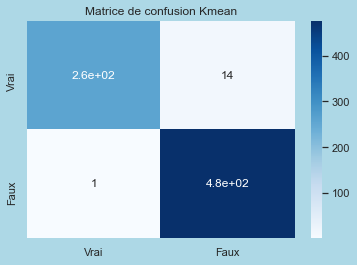

In [111]:
matrix_Kmean = confusion_matrix(ytest, ModelResults['Kmean'])
sns.heatmap(matrix_Kmean, annot=True, xticklabels=["Vrai","Faux"], yticklabels=["Vrai","Faux"],cmap='Blues').set_title('Matrice de confusion Kmean')
matrix_Kmean=pd.DataFrame(matrix_Kmean, index=['Vrai', 'Faux'], columns=['Vrai', "Faux"])
matrix_Kmean

Text(0.5, 1.0, 'predictions Kmean')

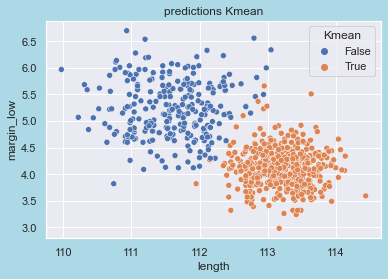

In [112]:
sns.scatterplot(xtest['length'],xtest['margin_low'], hue=ModelResults['Kmean']).set_title('predictions Kmean')

# Reconnaissance par la méthode des KNN

***C'est un algorithme de classification, on observe les K plus proches voisins pour déterminer la catégorie*** 

On va commencer par déterminer K en testant l'algorithme avec differentes valeurs de K (1, 5, 10, 50) et en comparant leurs résultats.

Text(0.5, 1.0, 'Swarmplot K=10')

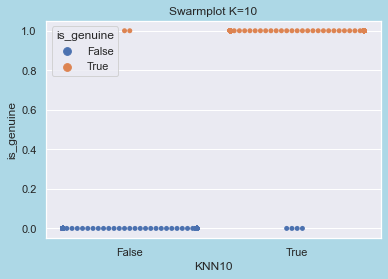

In [113]:
KNNResults = ModelResults[['is_genuine']]
KNNModel10 = KNeighborsClassifier(10).fit(xtrain, ytrain)
KNNResults['KNN10'] = KNNModel10.predict(xtest)
KNNModel10.score(xtest, ytest)
sns.swarmplot(KNNResults['KNN10'], ModelResults['is_genuine'], hue=ModelResults['is_genuine']).set_title('Swarmplot K=10')

Pour K=10 le nombre d'erreurs est assez faible.

Text(0.5, 1.0, 'Swarmplot K=5')

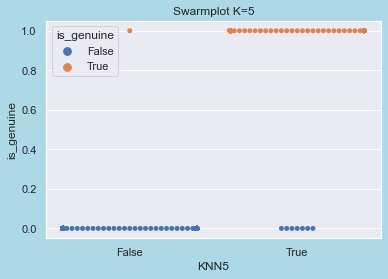

In [114]:
KNNModel = KNeighborsClassifier(5).fit(xtrain, ytrain)
ModelResults['KNN'] = KNNModel.predict(xtest)
KNNResults['KNN5'] = ModelResults['KNN']
KNNModel.score(xtest, ytest)
sns.swarmplot(KNNResults['KNN5'], ModelResults['is_genuine'], hue=ModelResults['is_genuine']).set_title('Swarmplot K=5')


Pour K=5 le nombre d'erreurs est comparable à K=10 il est donc préférable d'utiliser K=5

Text(0.5, 1.0, 'Swarmplot K=1')

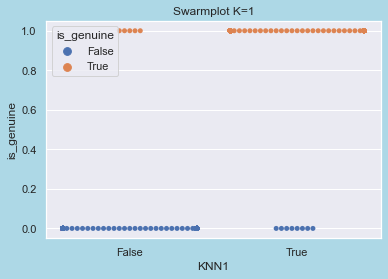

In [115]:
KNNModel1 = KNeighborsClassifier(1).fit(xtrain, ytrain)
KNNResults['KNN1'] = KNNModel1.predict(xtest)
KNNResults['KNN5'] = ModelResults['KNN']
KNNModel1.score(xtest, ytest)
sns.swarmplot(KNNResults['KNN1'], ModelResults['is_genuine'], hue=ModelResults['is_genuine']).set_title('Swarmplot K=1')

Pour K=1 les erreurs sont bien trop nombreuses, il est toujours préférable d'utiliser K=5

Text(0.5, 1.0, 'Swarmplot K=50')

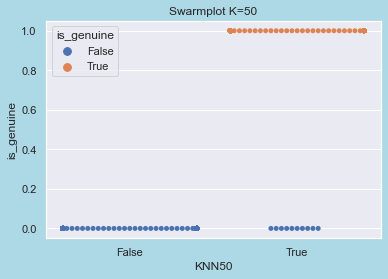

In [116]:
KNNModel50 = KNeighborsClassifier(50).fit(xtrain, ytrain)
KNNResults['KNN50'] = KNNModel50.predict(xtest)
KNNModel50.score(xtest, ytest)
sns.swarmplot(KNNResults['KNN50'], ModelResults['is_genuine'], hue=ModelResults['is_genuine']).set_title('Swarmplot K=50')

Pour K=50, il y'a plus d'erreurs qu'avec K=5.

Nouus utiliserons donc K=5 pour notre algorithme de KNN

<AxesSubplot:xlabel='KNN', ylabel='is_genuine'>

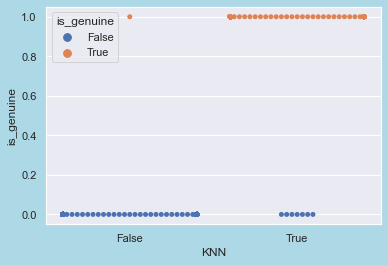

In [117]:
sns.swarmplot(ModelResults['KNN'], ModelResults['is_genuine'], hue=ModelResults['is_genuine'])

In [118]:
# on applique notre notation maison
ModelResults['KNN-Note'] = np.where(ModelResults['is_genuine']==ModelResults['KNN'],1 ,0)

## Matrice de confusion

,Vrai,Faux
Vrai,266,7
Faux,1,476


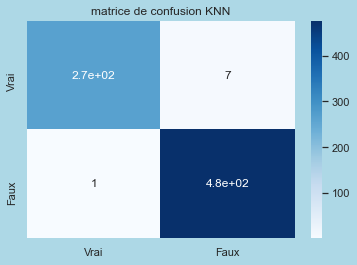

In [119]:
matrix_KNN = confusion_matrix(ytest, ModelResults['KNN'])
sns.heatmap(matrix_KNN, annot=True, xticklabels=["Vrai","Faux"], yticklabels=["Vrai","Faux"],cmap='Blues').set_title('matrice de confusion KNN')
matrix_KNN=pd.DataFrame(matrix_KNN, index=['Vrai', 'Faux'], columns=['Vrai', "Faux"])
matrix_KNN

Text(0.5, 1.0, 'predictions KNN')

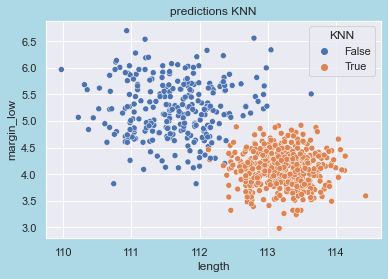

In [120]:
sns.scatterplot(xtest['length'],xtest['margin_low'], hue=ModelResults['KNN']).set_title('predictions KNN')

# Reconnaissance par la méthode de la regression logistique

***La regression logistique utilise un modèle linéaire généralisant une fonction logistique. C'est un modèle courament utilisé pour obtenir des résultats binaires***

In [121]:
LogiRegModel = LogisticRegressionCV(solver="newton-cg").fit(xtrain, ytrain)
#LogiRegModel = LogisticRegressionCV().fit(xtrain, ytrain)
ModelResults['LogiReg'] = LogiRegModel.predict(xtest)
LogiRegModel.score(xtest, ytest)

0.9906666666666667

In [122]:
ModelResults['LogiReg-Note'] = np.where(ModelResults['is_genuine']==ModelResults['LogiReg'],1 ,0)

on applique l'algorithme de regression logistique, et on applique notre petite notation maison.

## Matrice de confusion

,Vrai,Faux
Vrai,268,5
Faux,2,475


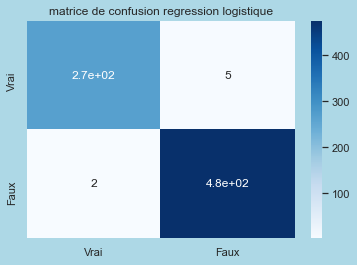

In [123]:
matrix_LogiReg = confusion_matrix(ytest, ModelResults['LogiReg'])
sns.heatmap(matrix_LogiReg, annot=True, xticklabels=["Vrai","Faux"], yticklabels=["Vrai","Faux"],cmap='Blues').set_title("matrice de confusion regression logistique")
matrix_LogiReg=pd.DataFrame(matrix_LogiReg, index=['Vrai', 'Faux'], columns=['Vrai', "Faux"])
matrix_LogiReg

Text(0.5, 1.0, 'predictions Regression logistique')

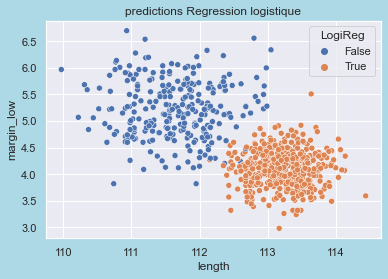

In [124]:
sns.scatterplot(xtest['length'],xtest['margin_low'], 
                hue=ModelResults['LogiReg']).set_title('predictions Regression logistique')

## Courbe de ROC

In [125]:
auc_roc = metrics.roc_auc_score(ytest, ModelResults['LogiReg'])
auc_roc

0.9887460547837907

In [126]:
taux_faux_positif, taux_original, thresholds = roc_curve(ytest, ModelResults['LogiReg'])
roc_auc = auc(taux_faux_positif, taux_original)
roc_auc

0.9887460547837907

Text(0.5, 0, 'False Positive Rate')

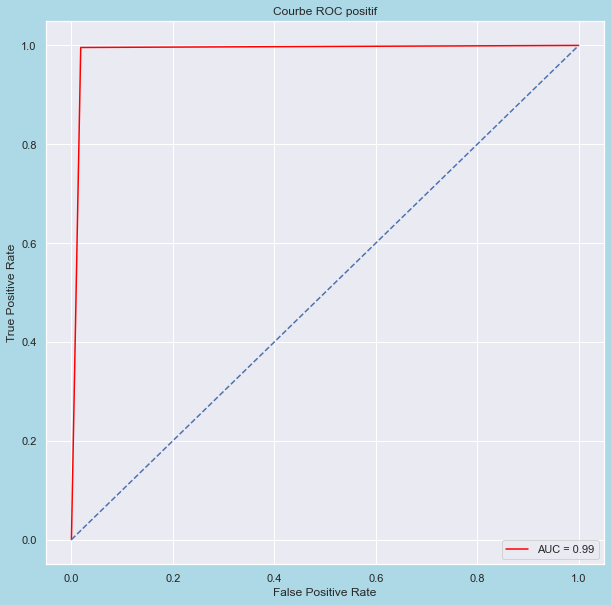

In [127]:
plt.figure(figsize=(10,10))
plt.title('Courbe ROC positif')
plt.plot(taux_faux_positif,taux_original, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

LA courbe de Roc sert à mesurer la performance d'un classificateur binaire. nous avons ici un très bon score.

# Comparaison de modèles

## généralités

on va se servir de notre petit fichier de notation maison construit au fil de l'essai des differents algorithmes pour les comparer entre eux.

In [128]:
ModelResults

,is_genuine,Naif,Naif-Note,Kmean,Kmean-Note,KNN,KNN-Note,LogiReg,LogiReg-Note
1483,False,False,1,False,1,False,1,False,1
1125,False,False,1,False,1,False,1,False,1
863,True,True,1,True,1,True,1,True,1
1060,False,False,1,False,1,False,1,False,1
1183,False,False,1,False,1,False,1,False,1
...,...,...,...,...,...,...,...,...,...
567,True,True,1,True,1,True,1,True,1
331,True,True,1,True,1,True,1,True,1
706,True,True,1,True,1,True,1,True,1
1281,False,False,1,True,0,True,0,False,1


In [129]:
ModelResults.describe()

,Naif-Note,Kmean-Note,KNN-Note,LogiReg-Note
count,750.000000,750.000000,750.000000,750.000000
mean,0.938667,0.980000,0.989333,0.990667
std,0.240101,0.140093,0.102796,0.096221
min,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,1.000000
50%,1.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000


On confirme que tous les algorithmes de ML employés ont de meilleurs résultats que notre alorithme naïf, et a prioris le plus performant serait la regression logistique.

Text(0.5, 1.0, 'Heatmap des prédictions de modèles')

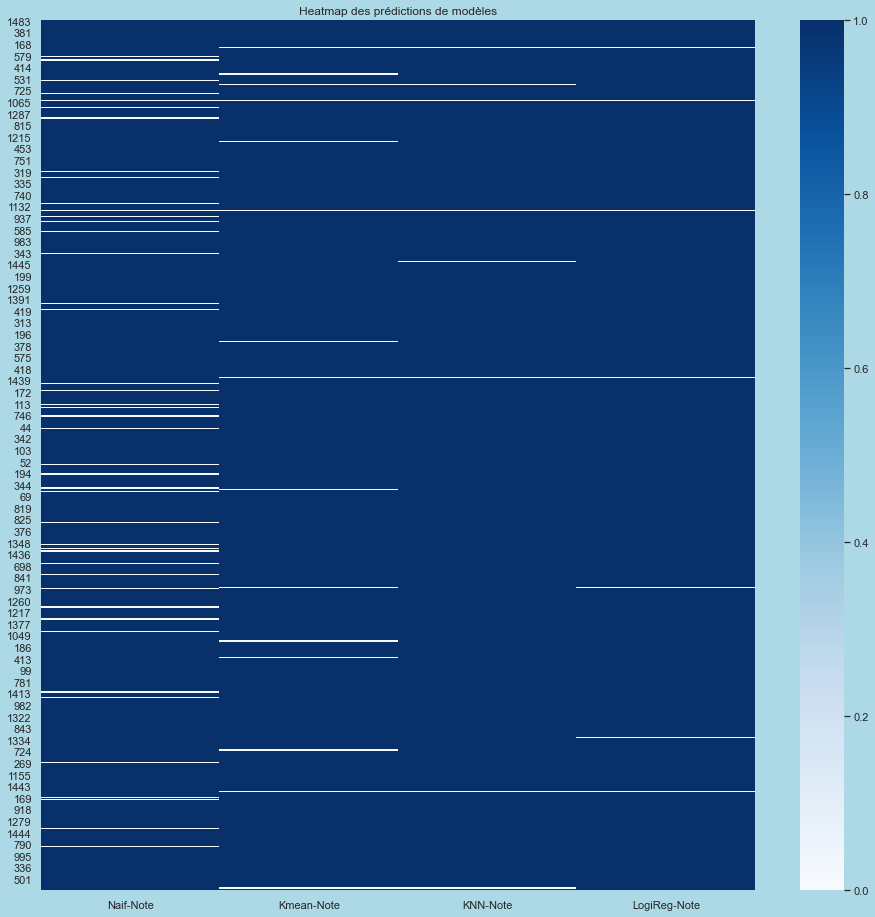

In [130]:
# heatmap des prédictions
ModelNotes = ModelResults[['Naif-Note', 'Kmean-Note', 'KNN-Note', 'LogiReg-Note']]
fig, axes= plt.subplots(figsize=(16,16))
sns.heatmap(ModelNotes, cmap='Blues').set_title('Heatmap des prédictions de modèles')

Chaque colonne etant un algorithme utilisé précédemment, une ligne bleue correspond à une prédiction correcte, et une ligne blanche à une erreur de prédiction.

La regression logistique est le modèle qui a prédit le plus correctement nos données de test.

In [175]:
# on récupère la liste des billets dont on a complété la valeur margin_low
cheese_list = cheese_data['is_genuine']
print(f'billets touchés par la régression linéaire: \n {cheese_list.index}')
# on récupère la liste des billets qui à posé problème à chaque algorithme
erreur_naif = ModelResults[ModelResults['Naif-Note']==0]
print(f'erreur méthode naïve: \n{erreur_naif.index.sort_values()}')

erreur_Kmean = ModelResults[ModelResults['Kmean-Note']==0]
print(f'erreur méthode Kmean: \n{erreur_Kmean.index.sort_values()}')

erreur_KNN = ModelResults[ModelResults['KNN-Note']==0]
print(f'erreur méthode KNN: \n{erreur_KNN.index.sort_values()}')

erreur_LogiReg = ModelResults[ModelResults['LogiReg-Note']==0]
print(f'erreur méthode LogiReg: \n{erreur_LogiReg.index.sort_values()}')



billets touchés par la régression linéaire: 
 Int64Index([  72,   99,  151,  197,  241,  251,  284,  334,  410,  413,  445,
             481,  505,  611,  654,  675,  710,  739,  742,  780,  798,  844,
             845,  871,  895,  919,  945,  946,  981, 1076, 1121, 1176, 1303,
            1315, 1347, 1435, 1438],
           dtype='int64')
erreur méthode naïve: 
Int64Index([   4,   75,  117,  139,  149,  169,  181,  214,  239,  255,  260,
             269,  275,  288,  300,  319,  341,  348,  351,  357,  392,  428,
             430,  436,  452,  471,  577,  591,  616,  623,  629,  632,  639,
             687,  755,  775,  832,  836,  849,  908,  915,  931,  973,  976,
             985, 1122],
           dtype='int64')
erreur méthode Kmean: 
Int64Index([ 591, 1024, 1026, 1062, 1073, 1078, 1083, 1103, 1122, 1130, 1223,
            1245, 1281, 1325, 1362],
           dtype='int64')
erreur méthode KNN: 
Int64Index([591, 1024, 1073, 1083, 1084, 1103, 1122, 1281], dtype='int64')
erreur méth

In [182]:
def compare_list(liste, modele):
    result=[]
    for element in liste:
        if element in modele:
            result += element
    return result

In [183]:
compare_list(erreur_naif, cheese_list)

[]

In [185]:
compare_list(erreur_Kmean, cheese_list)

[]

In [184]:
compare_list(erreur_KNN, cheese_list)

[]

In [186]:
compare_list(erreur_LogiReg, cheese_list)

[]

Aucun des billets sur lesquels nous avons appliqué précédement la regression linéaire n'est présent dans nos erreurs de prédiction.

On considère que la regression linéaire utilisée précédemment n'est donc pas une source d'erreur de classifications.

Text(0.5, 1.0, 'erreurs de predicition naïves')

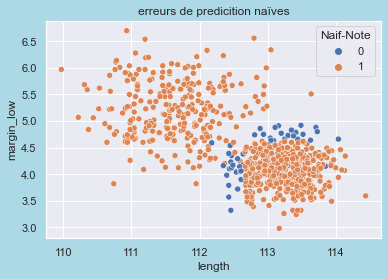

In [177]:
sns.scatterplot(xtest['length'],xtest['margin_low'], 
                hue=ModelResults['Naif-Note']).set_title('erreurs de predicition naïves')

Text(0.5, 1.0, 'erreurs de predicition Kmean')

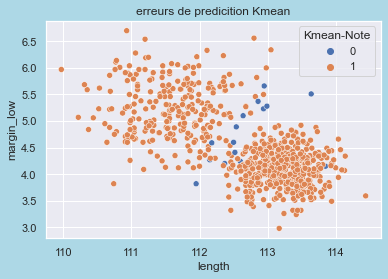

In [178]:
sns.scatterplot(xtest['length'],xtest['margin_low'], 
                hue=ModelResults['Kmean-Note']).set_title('erreurs de predicition Kmean')

Text(0.5, 1.0, 'erreurs de predicition KNN')

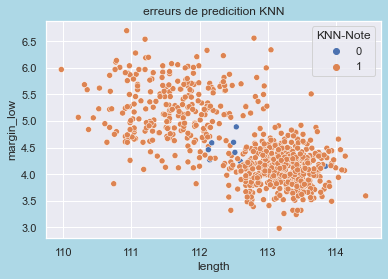

In [179]:
sns.scatterplot(xtest['length'],xtest['margin_low'], 
                hue=ModelResults['KNN-Note']).set_title('erreurs de predicition KNN')

Text(0.5, 1.0, 'erreurs de predicition LogiReg')

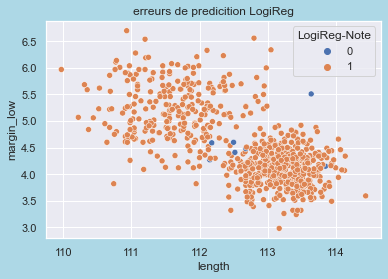

In [180]:
sns.scatterplot(xtest['length'],xtest['margin_low'], 
                hue=ModelResults['LogiReg-Note']).set_title('erreurs de predicition LogiReg')

C'est la regression logistique qui donne les erreurs les plus "regroupées" 

## RMSE - methode

In [132]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [133]:
Naifrmse = rmse(ModelResults['is_genuine'], ModelResults['Naif-Note'])
Kmeanrmse = rmse(ModelResults['is_genuine'], ModelResults['Kmean-Note'])
KNNrmse = rmse(ModelResults['is_genuine'], ModelResults['KNN-Note'])
LogiRegrmse = rmse(ModelResults['is_genuine'], ModelResults['LogiReg-Note'])

In [134]:
print(f'ecart Naif: {Naifrmse}')
print(f'ecart Kmean: {Kmeanrmse}')
print(f'ecart KNN: {KNNrmse}')
print(f'ecart regression logistique: {LogiRegrmse}')

ecart Naif: 0.6501281924871946
ecart Kmean: 0.5887840577551898
ecart KNN: 0.5966573556070519
ecart regression logistique: 0.6


# Predictions

Compte tenu de ses très bons résultats et de la possibilité d'obtenir un taux de confiance de la prédiction, nous avons choisi la regression logistique comme algorithme de prédiction.

Il est temps de l'utiliser pour prédire l'authenticité des billets.


In [135]:
# import csv et visu de contrôle
unknown = pd.read_csv('a_tester/billets_production.csv')
unknown.head()

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


On vérifiera ici que l'import s'est déroulé correctement.

(3.5, 6.5)

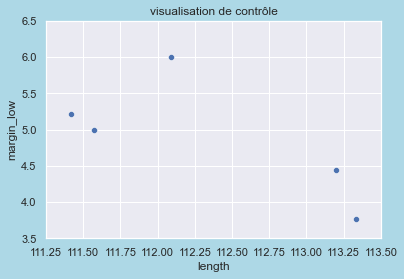

In [136]:
# Affichage des billets sous la forme d'un scatterplot
sns.scatterplot(unknown['length'], 
                unknown['margin_low'],
                legend='auto').set_title('visualisation de contrôle')


plt.xlim(111.25,113.5)                
plt.ylim(3.5,6.5)

on affiche rapidement chaque billet en fonction de sa marge basse sur sa longueur, ce qui nous permet au besoin de faire une estimation humaine avant de poursuivre.

In [137]:
billets_id = unknown[['id']]
billet_to_test = unknown.drop(columns=['id'])

In [138]:
# extraction des pourcentages
percent = LogiRegModel.predict_proba(billet_to_test)
percent = pd.DataFrame(percent)
# mise en forme
percent = round(percent,2)*100
percent = percent.astype(str)+ '%'

# concaténation avec l'id du billet fourni
test_results = pd.concat([billets_id, percent], axis=1)

# résultat du test
test_results['predict_genuinity'] = LogiRegModel.predict(billet_to_test)

# on colorie
test_results.style.applymap(color_df)

,id,0,1,predict_genuinity
0,A_1,100.0%,0.0%,False
1,A_2,100.0%,0.0%,False
2,A_3,100.0%,0.0%,False
3,A_4,2.0%,98.0%,True
4,A_5,0.0%,100.0%,True


affichage des résultats standards.

In [139]:
# si nécessaire on peut ajouter les dimensions des billets.
full_test_results = pd.concat([test_results, billet_to_test], axis=1)
full_test_results.style.applymap(color_df)



,id,0,1,predict_genuinity,diagonal,height_left,height_right,margin_low,margin_up,length
0,A_1,100.0%,0.0%,False,171.760000,104.010000,103.540000,5.210000,3.300000,111.420000
1,A_2,100.0%,0.0%,False,171.870000,104.170000,104.130000,6.000000,3.310000,112.090000
2,A_3,100.0%,0.0%,False,172.000000,104.580000,104.290000,4.990000,3.390000,111.570000
3,A_4,2.0%,98.0%,True,172.490000,104.550000,104.340000,4.440000,3.030000,113.200000
4,A_5,0.0%,100.0%,True,171.650000,103.630000,103.560000,3.770000,3.160000,113.330000


affichage des résultats avec les données dimensionnelles.

In [140]:
# si seul le résultat  compte, on peut aussi limiter la sortie à l'index et au résultats.
minimal_test_results = test_results[['id',"predict_genuinity"]]
minimal_test_results.style.applymap(color_df)

,id,predict_genuinity
0,A_1,False
1,A_2,False
2,A_3,False
3,A_4,True
4,A_5,True


affichage des résultats avec informations minimales.

(3.5, 6.5)

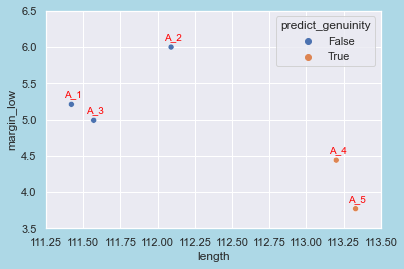

In [141]:
# Affichage des résultats sous la forme d'un scatterplot
sns.scatterplot(full_test_results['length'], 
                full_test_results['margin_low'], 
                hue=full_test_results['predict_genuinity'], 
                legend='full')
# affichage de l'id des billets sur le graphe, commenter si trop de billets dans le csv.
for i in range(full_test_results.shape[0]):
    plt.text(x=full_test_results.length[i]-0.05,y=full_test_results.margin_low[i]+0.1,s=full_test_results.id[i], 
          fontdict=dict(color='red',size=10))

plt.xlim(111.25,113.5)                #set x limit
plt.ylim(3.5,6.5)
          

Affichage des résultats sous la forme d'un scatterplot avec légendes et labels.